<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 - West Nile Virus Prediction

# Part 3 : Model Evaluation

## Contents:
* [Organisation of Notebooks](#Organisation-of-Notebooks)
* [Import Libraries and Dataset](#Import-Libraries-and-Dataset)
* [Methodology](#Methodology)
* [Train Test Split, Encoding and Standard Scaling](#Train-Test-Split,-Encoding-and-Standard-Scaling)
* [Oversample the Train set via SMOTE-NC](#Oversample-the-Train-set-via-SMOTE-NC)
* [Create dataframe of results](#Create-dataframe-of-results)
* [Create custom function](#Create-custom-function)
* [Naive accuracy and AUC_ROC scores](#Naive-accuracy-and-AUC_ROC-scores)
* [Model Evaluation](#Model-Evaluation)
* [Summary](#Summary)

## Organistation of Notebooks:
1. [Introduction](./01_Introduction.ipynb)
2. [EDA](./02_EDA.ipynb)
3. Model Evaluation
4. [Recommendation and Conclusion](./04_Recommendation_and_Conclusion.ipynb)

## Import libraries and Dataset

In [1]:
# # install xgboost package for the XGBClassifier
# !conda install -c conda-forge xgboost -y

In [2]:
# # install sklearn pandas package for DataFrameMapper
# !conda install -c conda-forge sklearn-pandas -y

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Preprocessing stuff
from sklearn.preprocessing import (
    LabelEncoder, 
    LabelBinarizer, 
    StandardScaler
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline


# Import SMOTENC to deal with categorical columns
# from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Import models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier, 
    AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier

# For creating mosquito clusters
from sklearn.cluster import (
    KMeans, 
    DBSCAN, 
    AgglomerativeClustering
)

# Performance measurement stuff
from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix, 
    f1_score,
    roc_auc_score, 
    plot_roc_curve, 
    roc_curve
)
# Measure runtime
import time

import warnings
warnings.filterwarnings('ignore')

# To calculate geo-distance
# !pip install haversine
# import haversine as hs

In [4]:
## Load files
train = pd.read_csv("../data/train_filtered_clean.csv")
test = pd.read_csv("../data/test_filtered_clean.csv")
kaggle = pd.read_csv("../data/sampleSubmission.csv")

In [5]:
test.head()

Id                 Species  Trap  Latitude  Longitude  Date_month  \
0   1  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991           6   
1   2          CULEX RESTUANS  T002  41.95469 -87.800991           6   
2   3           CULEX PIPIENS  T002  41.95469 -87.800991           6   
3   4        CULEX SALINARIUS  T002  41.95469 -87.800991           6   
4   5         CULEX TERRITANS  T002  41.95469 -87.800991           6   

   Date_week  Tmax  Tmin   Tavg  ...  WetBulb_lag5  WetBulb_lag6  \
0         24  86.0  63.5  74.75  ...          72.0          71.5   
1         24  86.0  63.5  74.75  ...          72.0          71.5   
2         24  86.0  63.5  74.75  ...          72.0          71.5   
3         24  86.0  63.5  74.75  ...          72.0          71.5   
4         24  86.0  63.5  74.75  ...          72.0          71.5   

   WetBulb_lag7  PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0          62.5             0.005             0.175             1.275   
1          62.5             0.005             0.175             1.275   
2          62.5             0.005             0.175             1.275   
3          62.5             0.005             0.175             1.275   
4          62.5             0.005             0.175             1.275   

   PrecipTotal_lag4  PrecipTotal_lag5  PrecipTotal_lag6  PrecipTotal_lag7  
0              0.09             0.015              0.43              0.01  
1              0.09             0.015              0.43              0.01  
2              0.09             0.015              0.43              0.01  
3              0.09             0.015              0.43              0.01  
4              0.09             0.015              0.43              0.01  

[5 rows x 55 columns]

## Methodology

These are our modeling assumptions:
- We remove duplicated rows with similar \['Date' & 'Species' & 'Trap'\], as they are created because of multiple mosquito test samples for that particular trap on that day. Removal of these duplicated rows is necessary, otherwise our models will give overly-heavy weights to Traps with a lot of test sample, e.g. Trap 'T115' with 64 rows (test samples) on '2007-07-25'. To be conservative, if at least test sample is positive for a particular \['Date' & 'Species' & 'Trap'\], we will assume all other test samples for that \['Date' & 'Species' & 'Trap'\] are positive. For example, if T115 has 3 out of 10 test samples that are positive for PIPENS/RESTUANS on 2007-07-25, we will assume all are positive so that we ensure that we get a positive value for WnvPresent after 9 out of 10 duplicated rows are dropped.
- Variables that we use are:
    - Species
    - Trap
    - Longitude
    - Latitude
    - Weather-related features: Tmax, Tmin, Tavg, DewPoint, WetBulb, PreciptTotal
    - Month 
    - Week of the year (not to be confused with week of the month)
- We assume that mosquitoes have a life cycle of 7 days, as seen in the graphics below. Any effect on the breeding of mosquitoes due to changes in weather might be seen only after a few days. Therefore, we also lagged the weather variables by up to 7 days (i.e. lag = 0, 1, 2, ..., 6, 7) in an attempt to capture these delayed effects.
- Species, Trap, Month, Week are one-hot encoded to dummies.

<div>
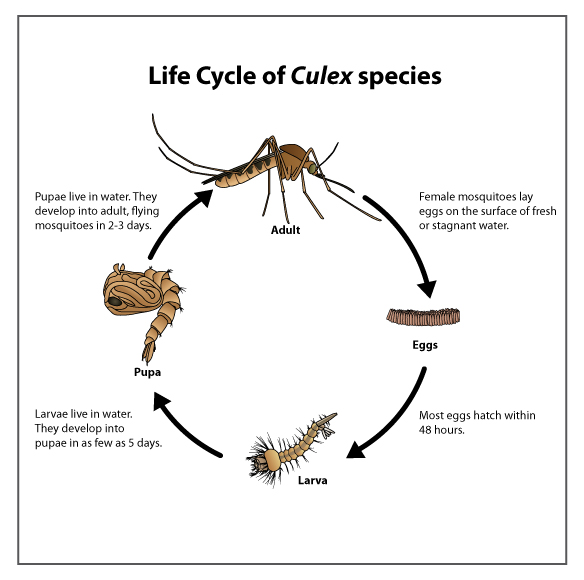
</div>

<div>
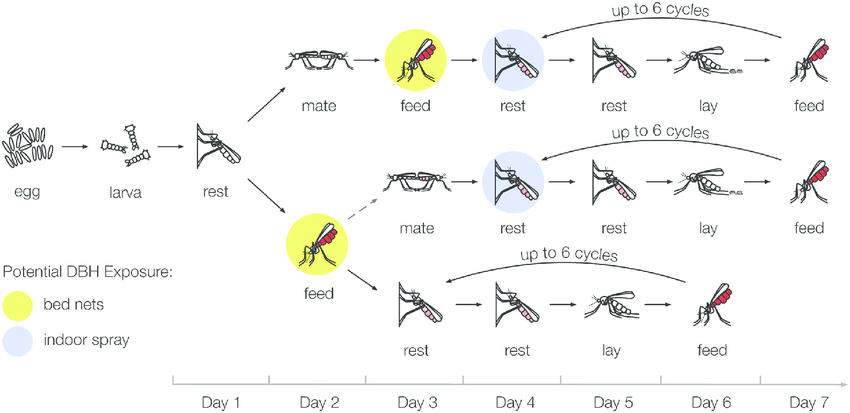
</div>


We break our analysis up into 7 steps:
- Step 1: We test our features on 6 basic models (Logistic, KNeighbors, Random Forest, Extra Trees, Support Vector, XGBoost).
- Step 2: We take the top two performing models in Section 1 and do an intensive grid search on them.
- Step 3: We take the finely-tuned models from Section 2, and drop the 'month' hot-encoded categories. Month of the year is correlated to week of the year, but it could provide useful predictive information. Dropping it is to check if the extra predictive ability is good enough to counteract the negative effects of collinearity. 
- Step 4: Lagged weather variables are time series in nature and suffers from auto-correlation, but it could provide predictive ability due to the life cycle of mosquitoes. Here we reduce the lagged weather variables from 7 days to 3 days, in the hope that we reduce the effects of collinearity without sacrificing too much predictive information.
- Step 5: We test out the scenario where the lag for weather variables are further reduced to just 1 day, i.e. we only have lag = 0 and lag = 1 in the model.
- Step 6: Here, we replace Longitude and Latitude with "mozzie clusters" formed by the KMeans algorithm. The reasoning is that while we see some evidence of more WNV-positive cases in the western parts of Chicago than eastern parts, using Long/Lat is too blunt an instrument. Ideally, it should be based on the built-up features and demographics of Chicago, e.g. landed housing areas are more prone to WNV, high population areas are more prone. Since we do not have such information, the next best step is to use a clustering algorithm to derive mosquito prone clusters. The KMeans algorithm is fitted with \['Longitude', 'Latitude', 'NumMosquitos' & 'WnvPresent'\]. 
- Step 7: Same as Section 6, but 'mozzie clusters' are estimated using the DBSCAN algorithm.

Assessment metric:
- We shall use ROC_AUC as the scoring method
- We shall first look at test score, followed by the average 5-fold CV score
- Finally we submit the Kaggle predictions to be used as 3rd set of scoring metric

## Train Test Split, Encoding and Standard Scaling

As seen above, two columns `Species` and `Trap` have dtype == 'objects' and hence are categorical features. Let's check if we have more categories in Test set that are not seen in the Train set, as that could lead to under-fitting issues.

In [6]:
print(f"No. of unique species in: \
\n train set: {train['Species'].nunique()} \
\n test set: {test['Species'].nunique()}")
print()
print(f"No. of unique traps in: \
\n train set: {train['Trap'].nunique()} \
\n test set: {test['Trap'].nunique()}")

No. of unique species in: 
 train set: 7 
 test set: 8

No. of unique traps in: 
 train set: 136 
 test set: 149


Indeed, there are more mosquito species in Train than Test. It can be a big problem if the 8th species happen to be a type that carries positive WNV (like PIPIENS, PIPENS/RESTUANS, RESTUANS), because any model will give it a strong negative likelihood because it has not seen that species before.

Same problem for Traps, as there are 13 more traps that are not seen and won't be fitted in the Train set. However, that is an easier problem to solve, as we can to create neighborhood clusters based on WnvPresent and GPS coordindates. KNN is then used to train and map these clusters to the Test set's GPS coordinates.

In [7]:
# Create X and Y, remove Latitude as it has no meaning looking at the EDA infection map
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6356, 54), (2119, 54), (6356,), (2119,))

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6356 entries, 4903 to 6053
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Species           6356 non-null   object 
 1   Trap              6356 non-null   object 
 2   Longitude         6356 non-null   float64
 3   Latitude          6356 non-null   float64
 4   Date_week         6356 non-null   int64  
 5   Date_month        6356 non-null   int64  
 6   Tmax              6356 non-null   float64
 7   Tmin              6356 non-null   float64
 8   Tavg              6356 non-null   float64
 9   DewPoint          6356 non-null   float64
 10  WetBulb           6356 non-null   float64
 11  PrecipTotal       6356 non-null   float64
 12  Tmax_lag1         6356 non-null   float64
 13  Tmax_lag2         6356 non-null   float64
 14  Tmax_lag3         6356 non-null   float64
 15  Tmax_lag4         6356 non-null   float64
 16  Tmax_lag5         6356 non-null   float

In [10]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_month', 'Date_week']
continuous_cols = [col for col in X.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

# Create Z_ data set for Kaggle, refitted based on full train set
Z = mapper.fit_transform(X)
Z_kaggle = mapper.transform(X_kaggle)

In [11]:
# Check transformed columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

display(Z_train)
display(Z_test)

Longitude  Latitude      Tmax      Tmin      Tavg  DewPoint   WetBulb  \
4903   1.856052 -1.731600 -1.594119 -0.414386 -1.093235 -0.484309 -0.796956   
6913  -0.107635 -1.309246  0.609664  0.963762  0.823648  1.405126  1.251968   
1962  -1.264778  1.028847  0.967034  0.241875  0.658399  0.019540  0.300682   
908   -0.158047 -1.512364  1.205281  0.766884  1.054996  0.397427  0.739737   
789    0.190851 -0.711055  1.205281  0.766884  1.054996  0.397427  0.739737   
...         ...       ...       ...       ...       ...       ...       ...   
7613   0.972873 -0.839114 -0.343323  0.504379  0.063505 -0.484309 -0.357901   
4235  -0.731318  0.557258 -1.713242 -0.217508 -1.060185  0.145503 -0.357901   
2855  -0.381302  0.628515 -2.487545 -1.858161 -2.316073 -1.617970 -2.040945   
5920   0.330629  0.219955  0.192732 -0.414386 -0.101744 -0.169403 -0.138373   
6053  -0.107635 -1.309246  1.383966  1.882528  1.715990  1.216183  1.398320   

      PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmax_lag4  Tmax_lag5  \
4903    -0.462624  -1.208497  -0.785583   1.012977  -0.124583   0.271211   
6913     1.526073   0.960578   0.242464   0.714293   0.335030  -0.875622   
1962    -0.462624   0.896782   0.484358  -0.062284  -0.518537  -0.620770   
908     -0.462624   1.151967   0.847198   0.535083  -0.058924   0.398637   
789     -0.462624   1.151967   0.847198   0.535083  -0.058924   0.398637   
...           ...        ...        ...        ...        ...        ...   
7613    -0.462624   1.151967   0.423885  -0.599914  -0.781173   0.016359   
4235     2.713355  -1.080904   0.242464  -0.181757  -0.912491  -1.449038   
2855    -0.195485  -0.251552  -0.967004  -0.181757  -0.649855  -2.149880   
5920    -0.462624   0.067430   1.330986  -0.838861   0.203712   0.080072   
6053    -0.462624   1.598542   0.847198  -0.360967  -0.255901  -0.365918   

      Tmax_lag6  Tmax_lag7  Tmin_lag1  Tmin_lag2  Tmin_lag3  Tmin_lag4  \
4903   0.473113   0.150502  -0.080830   0.309871   0.670165   0.622996   
6913  -1.481108  -0.826392   0.949019   0.742880  -0.188388  -0.601821   
1962   0.725270   1.336730   0.262453  -0.195306  -0.617665  -0.817965   
908    0.473113   0.429614   0.743049   0.093367   0.312434   0.767092   
789    0.473113   0.429614   0.743049   0.093367   0.312434   0.767092   
...         ...        ...        ...        ...        ...        ...   
7613   0.662231   0.080724   0.743049   0.670712  -0.331480  -0.385677   
4235  -0.787675  -0.337945  -0.012174  -0.411810  -1.046941  -0.817965   
2855  -0.724635  -0.826392  -1.591276  -2.288181  -1.619310  -1.466398   
5920  -0.031202   0.778505   0.193796   0.959384   0.169342  -0.385677   
6053   0.283995   0.290058   1.292302   0.309871  -0.045296  -0.385677   

      Tmin_lag5  Tmin_lag6  Tmin_lag7  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
4903   0.172591  -0.140136  -0.059584  -0.702205  -0.301769   0.898359   
6913  -0.311456  -0.291964  -0.335163   1.007906   0.496303   0.318206   
1962  -0.588055   0.846750   0.767155   0.624004   0.184014  -0.330201   
908    1.002387   0.315350   1.111629   1.007906   0.531001   0.454713   
789    1.002387   0.315350   1.111629   1.007906   0.531001   0.454713   
...         ...        ...        ...        ...        ...        ...   
7613   0.310890   0.087607  -0.197374   1.007906   0.565700  -0.500834   
4235  -0.726354  -0.595621   0.215996  -0.597504  -0.058878  -0.603214   
2855  -1.141252  -0.975193  -1.093007  -0.946507  -1.655021  -0.876228   
5920   0.310890   0.619007   0.422680   0.135400   1.224976  -0.398454   
6053  -0.242307   0.391264  -0.335163   1.531410   0.635098  -0.227821   

      Tavg_lag4  Tavg_lag5  Tavg_lag6  Tavg_lag7  DewPoint_lag1  \
4903   0.246030   0.236656   0.209875   0.048014       0.031520   
6913  -0.118484  -0.639500  -1.013982  -0.620911       0.903118   
1962  -0.701707  -0.639500   0.840347   1.125728       0.218291   
908    0.355384   0.727303   0.432395   0.828428       0.156034   
789    0.355384   0.727303   0.

Longitude  Latitude      Tmax      Tmin      Tavg  DewPoint   WetBulb  \
5602   1.762129 -0.970188  0.252294  0.832510  0.559250  1.090220  0.959264   
794    0.337268 -0.205359  1.205281  0.766884  1.054996  0.397427  0.739737   
1934  -0.669246  1.258152  0.967034  0.241875  0.658399  0.019540  0.300682   
3580   0.190851 -0.711055 -1.355872 -0.742517 -1.126284 -0.988158 -1.162835   
5990  -1.313179  1.207739  1.443528  1.226267  1.418542  1.405126  1.544671   
...         ...       ...       ...       ...       ...       ...       ...   
572    1.128261 -1.598088  0.311856  0.963762  0.658399  0.145503  0.300682   
3408  -0.501174 -0.427995  0.192732  0.241875  0.228753  0.649352  0.447034   
1829   0.190851 -0.711055 -0.105076  0.766884  0.327902  0.964258  0.666561   
641    0.481460  0.210906  0.192732  0.898136  0.559250  1.027239  0.812913   
1723  -1.642802  0.937128 -0.105076  0.766884  0.327902  0.964258  0.666561   

      PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmax_lag4  Tmax_lag5  \
5602    -0.462624   0.258819   0.726252   1.490871   1.385575   1.354331   
794     -0.462624   1.151967   0.847198   0.535083  -0.058924   0.398637   
1934    -0.462624   0.896782   0.484358  -0.062284  -0.518537  -0.620770   
3580    -0.462624   0.003633   0.605305  -0.002547  -0.255901   0.271211   
5990    -0.462624   0.832986  -0.362270  -0.241494  -0.452878   0.271211   
...           ...        ...        ...        ...        ...        ...   
572     -0.462624   0.131226   0.242464   0.057190  -0.781173  -0.684483   
3408    -0.165803  -0.187756  -1.692684  -0.480441   0.663326   0.207498   
1829     0.190381   0.896782   1.149565   0.654557  -0.452878  -1.449038   
641     -0.150962   0.322615   0.423885   0.176663   0.269371   0.143785   
1723     0.190381   0.896782   1.149565   0.654557  -0.452878  -1.449038   

      Tmax_lag6  Tmax_lag7  Tmin_lag1  Tmin_lag2  Tmin_lag3  Tmin_lag4  \
5602   1.418703   0.708727   0.811706   1.392393   1.600264   1.775764   
794    0.473113   0.429614   0.743049   0.093367   0.312434   0.767092   
1934   0.725270   1.336730   0.262453  -0.195306  -0.617665  -0.817965   
3580   0.662231   0.290058   0.193796   0.454207  -0.760757   0.118659   
5990   0.410073   0.080724   0.262453  -0.050970  -0.403027  -0.241581   
...         ...        ...        ...        ...        ...        ...   
572    0.347034   0.569170   0.262453  -0.195306  -0.474573  -0.673869   
3408  -1.355029  -0.268167  -0.286800  -0.195306  -0.116842  -0.169533   
1829  -1.418069  -0.198389   0.880362   0.959384   0.884803   0.767092   
641   -0.661596  -0.896170   0.262453   1.103720   0.312434  -0.169533   
1723  -1.418069  -0.198389   0.880362   0.959384   0.884803   0.767092   

      Tmin_lag5  Tmin_lag6  Tmin_lag7  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
5602   1.071536   0.694921   1.387208   0.554203   1.086181   1.615019   
794    1.002387   0.315350   1.111629   1.007906   0.531001   0.454713   
1934  -0.588055   0.846750   0.767155   0.624004   0.184014  -0.330201   
3580  -0.518905   0.391264   0.353785   0.100500   0.565700  -0.364327   
5990   0.380040  -0.443793   0.284890   0.589103  -0.232371  -0.330201   
...         ...        ...        ...        ...        ...        ...   
572   -0.380606   0.011693   0.904944   0.205201   0.045219  -0.193694   
3408  -0.518905  -0.291964   0.009311  -0.248502  -1.065142  -0.330201   
1829  -0.104007  -0.519707   0.009311   0.938106   1.120880   0.795979   
641   -0.449755  -0.747450  -0.335163   0.309902   0.773893   0.249953   
1723  -0.104007  -0.519707   0.009311   0.938106   1.120880   0.795979   

      Tavg_lag4  Tavg_lag5  Tavg_lag6  Tavg_lag7  DewPoint_lag1  \
5602   1.667636   1.288042   1.174127   1.125728       0.903118   
794    0.355384   0.727303   0.432395   0.828428       0.156034   
1934  -0.701707  -0.639500   0.840347   1.125728       0.218291   
3580  -0.082033  -0.113806   0.580741   0.345315      -0.342022   
5990  -0.373644   0.341794   0.

## Oversample the Train set via SMOTE-NC

In [12]:
# Check for imbalance dataset
y_train.value_counts(normalize = True)

0    0.946035
1    0.053965
Name: WnvPresent, dtype: float64

As seen above, the WNV is only present in about 5% of the dataset. This means that a 'lazy' model can always predict WnvPresent = 0 and still achieve a high accuracy score of 95%. To avoid training a model this way, we will use the SMOTE function to oversample the minority variable to achieve a 50-50 breakdown between Positive and Negative WNV cases.

Within the SMOTE family, there are `SMOTE, SMOTENC, SMOTEN` functions, where the first is the default, the second deals with dataset continaing numerical and categorical features, and the third deals with dataset only made of categorical features.

We tested both versions `SMOTE, SMOTENC` and found that the latter provides better prediction results.


In [13]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train.columns[:34]
cat_col_names = Z_train.columns[34:]
num_col_names, cat_col_names

(Index(['Longitude', 'Latitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'PrecipTotal', 'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmax_lag4',
        'Tmax_lag5', 'Tmax_lag6', 'Tmax_lag7', 'Tmin_lag1', 'Tmin_lag2',
        'Tmin_lag3', 'Tmin_lag4', 'Tmin_lag5', 'Tmin_lag6', 'Tmin_lag7',
        'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'Tavg_lag4', 'Tavg_lag5',
        'Tavg_lag6', 'Tavg_lag7', 'DewPoint_lag1', 'DewPoint_lag2',
        'DewPoint_lag3', 'DewPoint_lag4', 'DewPoint_lag5'],
       dtype='object'),
 Index(['DewPoint_lag6', 'DewPoint_lag7', 'WetBulb_lag1', 'WetBulb_lag2',
        'WetBulb_lag3', 'WetBulb_lag4', 'WetBulb_lag5', 'WetBulb_lag6',
        'WetBulb_lag7', 'PrecipTotal_lag1',
        ...
        'Date_week_32', 'Date_week_33', 'Date_week_34', 'Date_week_35',
        'Date_week_36', 'Date_week_37', 'Date_week_38', 'Date_week_39',
        'Date_week_40', 'Date_week_41'],
       dtype='object', length=183))

In [14]:
cat_col_index = list(range(len(num_col_names),len(Z_train.columns)))

In [15]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_sm, y_train_sm = sm.fit_resample(Z_train, y_train)

CPU times: user 12.3 s, sys: 277 ms, total: 12.6 s
Wall time: 12.8 s


In [16]:
%%time
# This is for Kaggle submission purposes, as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_sm, y_sm = sm.fit_resample(Z, y)

CPU times: user 16.6 s, sys: 295 ms, total: 16.9 s
Wall time: 17 s


In [17]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [18]:
# Check
Z_train.shape, Z_train_sm.shape

((6356, 217), (12026, 217))

In [19]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_sm = pd.DataFrame(Z_train_sm, columns = Z_train.columns)
Z_train_sm

Z_sm = pd.DataFrame(Z_sm, columns = Z.columns)
Z_sm

Longitude  Latitude      Tmax      Tmin      Tavg  DewPoint   WetBulb  \
0       0.205527 -1.057153  0.796179 -0.073249  0.404172 -0.093933  0.165484   
1      -1.263449  1.032541  0.796179 -0.073249  0.404172 -0.093933  0.165484   
2      -1.546838  1.214515  0.796179 -0.073249  0.404172 -0.093933  0.165484   
3       0.482575  0.210971  0.796179 -0.073249  0.404172 -0.093933  0.165484   
4       0.006295  0.700966  0.796179 -0.073249  0.404172 -0.093933  0.165484   
...          ...       ...       ...       ...       ...       ...       ...   
16031  -0.688873  0.797000 -0.811800 -0.923190 -0.915736 -0.973304 -0.930033   
16032   1.122237 -1.327541 -0.335362  0.515172  0.074195 -0.470806 -0.345757   
16033  -1.074045 -0.218423  0.915289  1.299733  1.163120  0.911063  0.968864   
16034   0.268483  1.337381 -0.394917  0.580552  0.074195  0.911063  0.603691   
16035  -0.924071 -0.542230  0.557960  0.776692  0.701152  1.350748  1.114933   

       PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmax_lag4  Tmax_lag5  \
0        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
1        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
2        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
3        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
4        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
...            ...        ...        ...        ...        ...        ...   
16031    -0.458229  -1.199350  -1.197616   0.365025   0.275767   0.148613   
16032    -0.458229   1.157612   0.427709  -0.587727  -0.772449   0.021095   
16033    -0.443508   0.775402   0.788893   1.615511   2.568740   2.507700   
16034     0.410304   1.221313   0.909287   0.603212   0.079227   0.021095   
16035    -0.443508  -0.498632  -1.438405  -1.421384  -0.117314  -0.361460   

       Tmax_lag6  Tmax_lag7  Tmin_lag1  Tmin_lag2  Tmin_lag3  Tmin_lag4  \
0       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
1       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
2       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
3       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
4       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
...          ...        ...        ...        ...        ...        ...   
16031   0.412004  -0.337218  -0.821002  -0.395151   0.749587  -0.157689   
16032   0.662680   0.079561   0.751008   0.679939  -0.313314  -0.372490   
16033   1.602716   1.607750   1.229446   1.038302   1.103887   2.276715   
16034   0.286666  -0.892923   0.819356   0.608266  -0.384174  -0.300889   
16035   0.098658   0.426877   0.682660  -0.108460  -0.455035  -0.014489   

       Tmin_lag5  Tmin_lag6  Tmin_lag7  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
0       0.248878   0.019502  -0.681180  -1.002035  -0.704091  -1.773145   
1       0.248878   0.019502  -0.681180  -1.002035  -0.704091  -1.773145   
2       0.248878   0.019502  -0.681180  -1.002035  -0.704091  -1.773145   
3       0.248878   0.019502  -0.681180  -1.002035  -0.704091  -1.773145   
4       0.248878   0.019502  -0.681180  -1.002035  -0.704091  -1.773145   
...          ...        ...        ...        ...        ...        ...   
16031   0.455282  -0.357167   0.624214  -1.071525  -0.876593   0.566563   
16032   0.317680   0.094836  -0.200246   1.013178   0.572427  -0.484610   
16033   1.693707   2.354850   2.479247   1.047923   0.951932   1.448193   
16034  -0.576738  -0.959837  -0.887295   1.082668   0.813930   0.159658   
16035   0.455282   1.300177   0.349394   0.075062  -0.876593  -1.027151   

       Tavg_lag4  Tavg_lag5  Tavg_lag6  Tavg_lag7  DewPoint_lag1  \
0      -1.343049   0.698396   0.693250   0.082523      -1.376441   
1      -1.343049   0.698396   0.693250   0.082523      -1.376441   
2      -1.343049   0.698396   0.693250   0.082523      -1.376441   
3      -1.343049   0.698396   0.693250   0.0825

## Create dataframe of results

In [20]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Classifier',
        'CV Score (train)',
        'ROC_AUC (train)',
        'ROC_AUC (test)',
#         'Sensitivity (test)',
        'Kaggle Score',
        'Runtime (sec)',
        'Remarks'
    ]
)
df_results

Empty DataFrame
Columns: [Model No., Classifier, CV Score (train), ROC_AUC (train), ROC_AUC (test), Kaggle Score, Runtime (sec), Remarks]
Index: []

## Create custom function

In [21]:
# Create function to run pipe and print results
def run_grid(Z_train_sm, Z_test, y_train_sm, y_test):
    
    # Start 'stopwatch' to measure runtime
    tic = time.time()
    
    # Instantiate RandomizedSearchCV
    gs = RandomizedSearchCV(
        model, 
        param_distributions = params, 
        n_jobs = -1, 
        cv = 5,
        verbose = 2,
        scoring = 'roc_auc'
    )

    # Fit model
    gs.fit(Z_train_sm, y_train_sm)

    # Confusion matrix
    y_pred = gs.predict(Z_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # End 'stopwatch' 
    toc = time.time()
    time_taken = toc - tic 
    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Classifier' : model,
        'CV Score (train)' : round(gs.best_score_, 3),
        'ROC_AUC (train)': round(gs.score(Z_train_sm, y_train_sm), 3),
        'ROC_AUC (test)' : round(gs.score(Z_test, y_test) ,3 ),
#         'Sensitivity (test)' : round (tp/(tp+fn), 3),
        'Runtime (sec)' : round(time_taken),
    }]
    
    # Print best parameters from RandomizedSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

## Naive accuracy and AUC_ROC scores

In [22]:
# Check WNV-positive cases
y.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

A naive model would always give a negative prediction as it can generate an accuracy of 94.6% due to the low frequency of WNV-positive cases. A better way to gauge effectiveness of such imbalanced datasets would be to use the AUC_ROC score.

In [23]:
# Baseline AUC_ROC score
roc_auc_score(y_true = y, y_score = [0]*len(y))

0.5

A naive model would generate an AUC_ROC score of 0.5 (1.0 being perfect) as it has no discrimination capacity to distinguish between positive and negative cases, as seen in the illustrated graphs below. This is because by always predicting negative cases, the true positive value will always be zero and the false positive value will always be zero, so the slope of the ROC line is always one because the ROC plots the True Positive Rate against the False Positive Rate. Therefore, our AUC_ROC score to beat is 0.5!

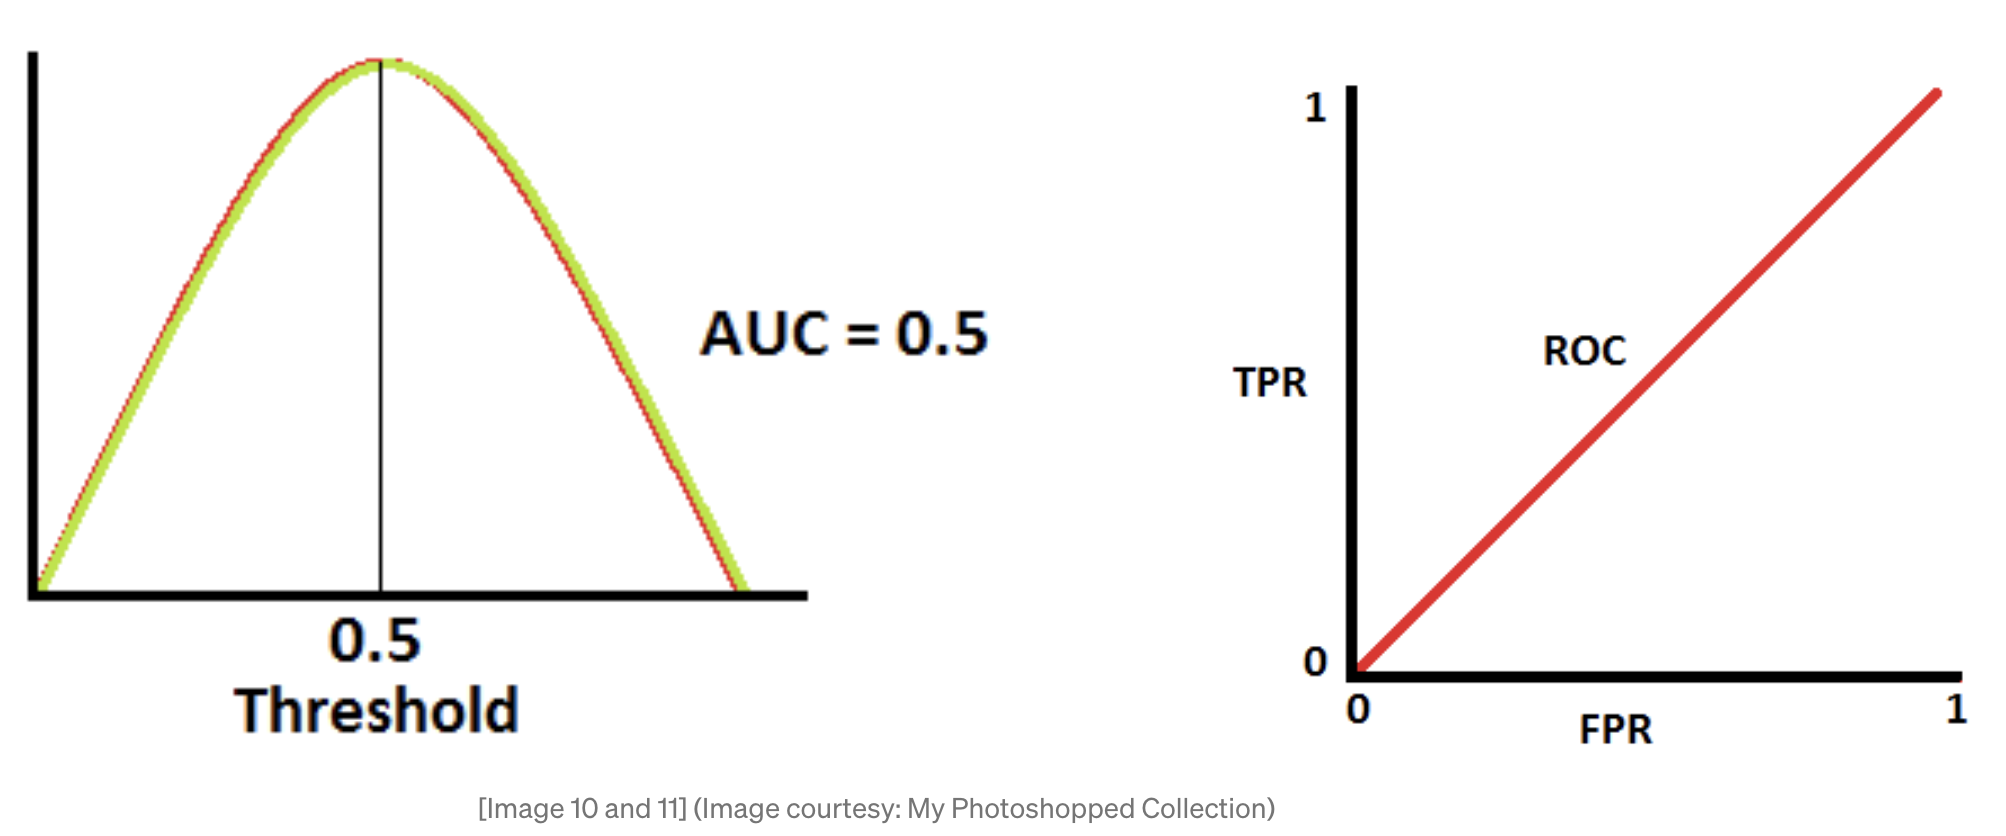

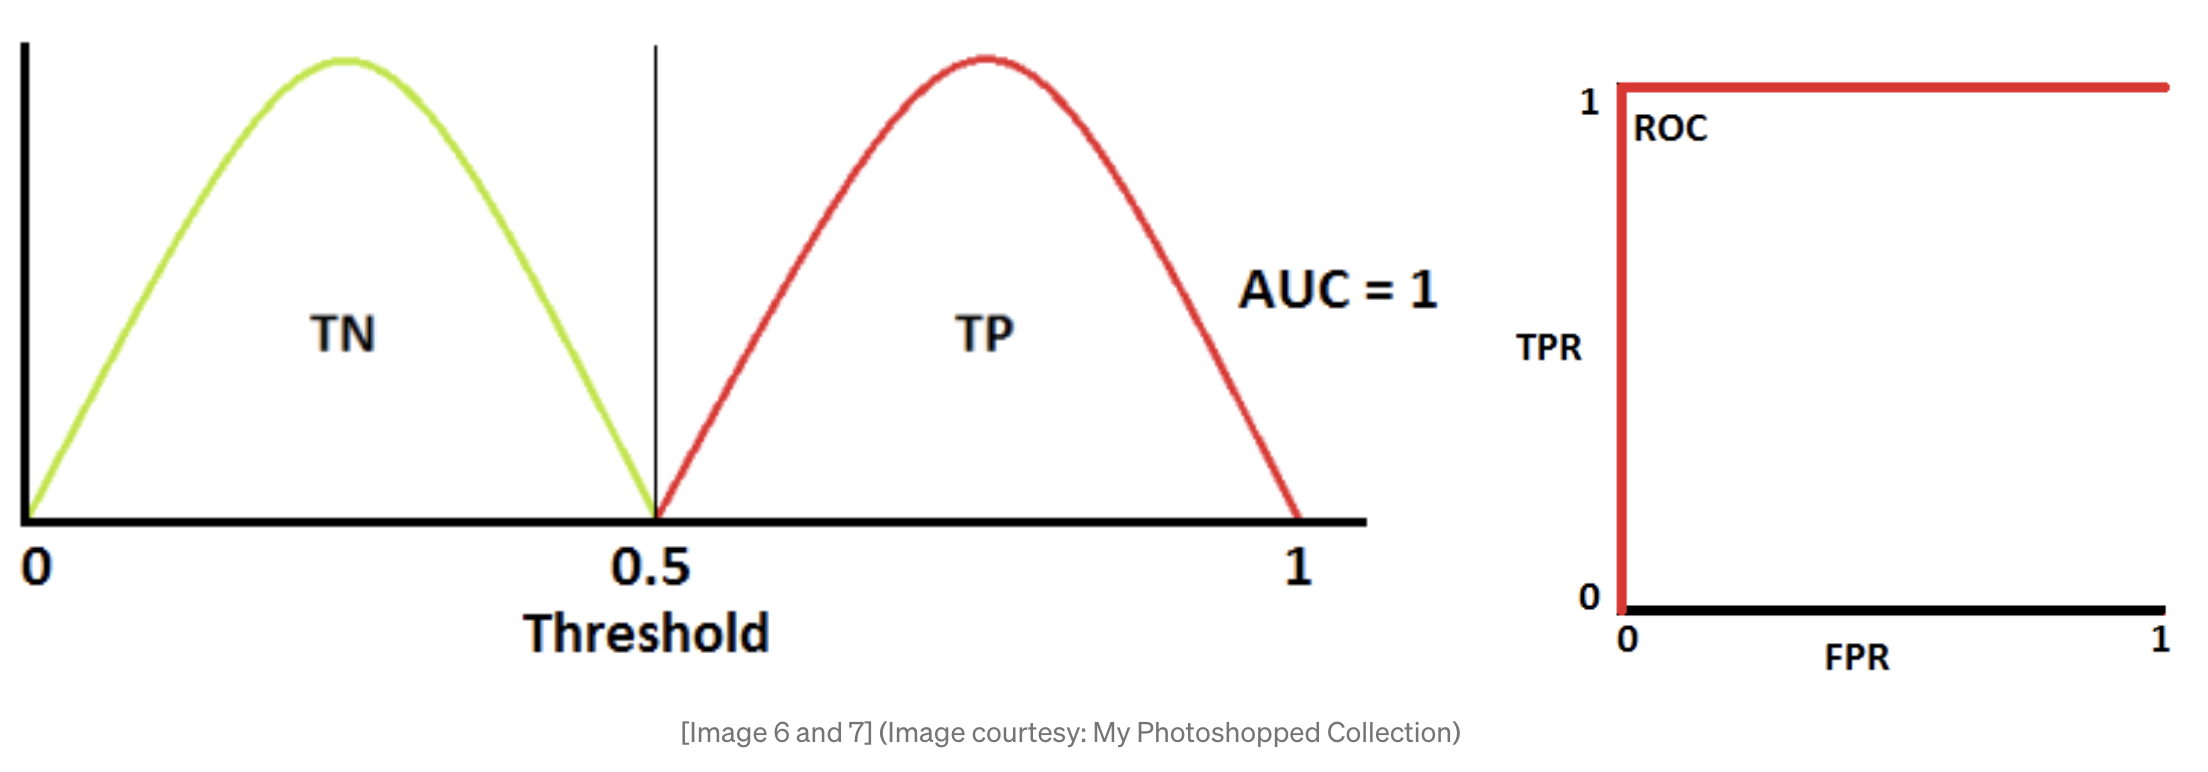

## Model Evaluation

### Step 1 (Baseline)

#### Logistic Regression

In [24]:
%%time
# 10sec
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
CPU times: user 606 ms, sys: 269 ms, total: 876 ms
Wall time: 7.28 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994            0.83          NaN   

  Runtime (sec) Remarks  
0             7     NaN

In [25]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_1.csv', index=False)

Training ROC AUC: 0.993


In [26]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 1, 'Kaggle Score'] = 0.684
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994            0.83        0.684   

  Runtime (sec) Remarks  
0             7     NaN

#### KNeighbors

In [27]:
%%time
# 1min
# Instantiate model
model = KNeighborsClassifier()

# Set parameters for CV
params = {
    'n_neighbors': list(range(2, 10)),
    'p': [1, 2],
    'leaf_size': [5, 10, 15], 
    'weights': ['uniform', 'distance']}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 8, 'leaf_size': 15}
CPU times: user 12.3 s, sys: 3.86 s, total: 16.2 s
Wall time: 27.7 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776          NaN   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN

Logistic Regression has a better ROC_AUC test score than KNN. Overfitting is observed for KNN as the test score is much lower than the test score. Let's move on to Random Forests to see if it performs better.

In [28]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 9, 'leaf_size': 5}
best_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2,
    n_neighbors = 9,
    leaf_size = 5
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_2.csv', index=False)

Training ROC AUC: 1.000


In [29]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 2, 'Kaggle Score'] = 0.596
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN

#### Random Forest

In [30]:
%%time
# 1min
# Instantiate model
model = RandomForestClassifier(random_state = 42)

# Set parameters for CV
params = {
    'n_estimators': [10, 20, 50, 100, 150, 200],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': None}
CPU times: user 11.1 s, sys: 103 ms, total: 11.2 s
Wall time: 33.2 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804          NaN   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN

Like the KNN, Random Forest also faces overfitting issue because the train ROC_AUC is near perfect but test ROC_AUC is so much lower.

In [31]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': None}
best_model = RandomForestClassifier(
    random_state = 42,
    n_estimators = 200,
    min_samples_leaf = 2,
    max_features = None
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_3.csv', index=False)

Training ROC AUC: 0.999


In [32]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 3, 'Kaggle Score'] = 0.643
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN

#### Extra Trees

In [33]:
%%time
# 1min
# Instantiate model
model = ExtraTreesClassifier(random_state = 42)

# Set parameters for CV
params = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [None, 3, 5, 7], #def: None
    'min_samples_split': [2, 3, 4, 5], #def:2, minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5] #def:1, minimum number of samples required to be at a leaf node
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None}
CPU times: user 15.6 s, sys: 432 ms, total: 16 s
Wall time: 1min 35s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809          NaN   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN

Though ExtraTrees has a perfect train ROC_AUC score, it can be observed that there is overfitting for ExtraTrees as the ROC_AUC test score is alot lower than the train ROC_AUC score.

In [34]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None}
best_model = ExtraTreesClassifier(
    n_estimators = 1_000,
    min_samples_split = 4,
    min_samples_leaf = 1,
    max_depth = None
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_4.csv', index=False)

Training ROC AUC: 1.000


In [35]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 4, 'Kaggle Score'] = 0.71
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN

#### Support Vector Machines

In [36]:
%%time
# 6min
# Instantiate model
model = SVC(
    max_iter = 10_000,
    kernel = 'rbf',
    random_state = 42
)

# Set parameters for CV
params = {
    'C': np.linspace(0.0001, 1, 20)
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 0.9473736842105264}
CPU times: user 18 s, sys: 388 ms, total: 18.4 s
Wall time: 2min 25s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803          NaN   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN  
0           136     NaN

Support Vector performs better than all the models except for Logistic Regression, however it can be observed that the test ROC_AUC is also much lower than the train ROC_AUC score which will also have overfitting issue.

In [37]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: Best Parameters: {'C': 0.8947473684210527}
best_model = SVC(
    max_iter = 10_000,
    kernel = 'rbf',
    random_state = 42,
    C = 0.8947473684210527
)

# Fit it 
best_model.fit(Z_sm, y_sm)
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
# y_pred = best_model.predict_proba(Z_kaggle)[:,1]
y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_5.csv', index=False)

Training ROC AUC: 0.890


In [38]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 5, 'Kaggle Score'] = 0.598
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN  
0           136     NaN

#### XGBoost

In [39]:
df_results = df_results[:5]

In [40]:
%%time
# 3min
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:37:58] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 11, 'learning_rate': 0.5}
CPU times: user 33.2 s, sys: 851 ms, total: 34.1 s
Wall time: 2min 12s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831          NaN   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN  
0           136     NaN  
0           133     NaN

XGBoost seems to work quite well looking at the CV Score, ROC_AUC score for train and test dataset along with Logistis Regression, Hence there are the 2 models that are selected for the next step.

In [41]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 5, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 5, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
# y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_6.csv', index=False)

[12:38:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.997


In [42]:
# Enter Kaggle sco
df_results.loc[df_results['Model No.'] == 6, 'Kaggle Score'] = 0.697
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN  
0           136     NaN  
0           133     NaN

### Step 2 (Fine-tuning)

In this section, we shortlist two models from Section 1 to do further fine-tuning
- Model 1 (logistic regression) has the best test/validation score and the second highest 5-fold CV score from the train set. 
- Model 6 (XGBoost) has the best 5-fold CV score and the highest Kaggle score, while maintaining a respectable test/validation score.

We proceed to fine tune Models 1 and 6 in this section.

#### Logistic Regression

In [43]:
%%time
# Instantiate model
model = LogisticRegression(
    random_state = 42
)

# Set parameters for CV
params = {
    'solver' : ['liblinear', 'saga'], 
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 100],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000, 'C': 8}
CPU times: user 11.9 s, sys: 182 ms, total: 12.1 s
Wall time: 2min 56s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828          NaN   

  Runtime (sec) Remarks  
0             7     NaN  
0            24     NaN  
0            33     NaN  
0            93     NaN  
0           136     NaN  
0           133     NaN  
0           176     NaN

The hyperparameter tuning did not change the penalty choice (still l2) and the choice of C changed from 10 to 9. However, the CV score and train score stayed unchanged while the test score dropped abit from 0.83 to 0.829.

In [44]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 7}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 7
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_7.csv', index=False)

Training ROC AUC: 0.993


In [45]:
# Add comments to Remarks column
df_results.loc[df_results['Model No.'] == 7, 'Kaggle Score'] = 0.684
df_results.loc[df_results['Model No.'] == 7, 'Remarks'] = 'Cousin of Model 1, a lot of tuning'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning

The Kaggle score for Model 7 is improved over Model 1 from 0.659 to 0.662, so finetuning seems to work.

#### XGBoost 

In [46]:
%%time
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8], 
    'subsample' : [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9], 
    'reg_alpha' : [0, 1, 1.5, 2, 2.5],
    'reg_lambda' : [1, 2, 3, 4, 5],
    'gamma' : [0.01, 0.02, 0.03, 0.04, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 1.5, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.05, 'eval_metric': 'auc'}
CPU times: user 22.5 s, sys: 993 ms, total: 23.5 s
Wall time: 1min 44s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104                                 NaN

Model 8's score remained roughly unchanged for CV score and ROC_AUC train score, while test ROC_AUC score is slightly higher than Model 6's (0.81 vs 0.803). This means that fine-tuning the XGBoost model's hyperparameters can result in improvement on the ROC_AUC test score.

In [47]:
## Create Kaggle submission file, but refit best model on full Train set

# {'subsample': 0.85, 'reg_lambda': 4, 'reg_alpha': 0, 'max_depth': 7, 'learning_rate': 0.8, 'gamma': 0.04, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.85,
    reg_lambda = 4, 
    reg_alpha = 0, 
    max_depth = 7, 
    learning_rate = 0.8, 
    gamma = 0.04,                   
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
# y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_8.csv', index=False)

[12:42:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 1.000


In [48]:
# Add comments to Remarks column
df_results.loc[df_results['Model No.'] == 8, 'Remarks'] = 'Cousin of Model 6, a lot of tuning'
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 8, 'Kaggle Score'] = 0.658
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning

When we tuned XGBoost with a lot more hyperparameters, there is an issue in overfitting as we compared the test score and Kaggle score of model 6 and model 8. Hence, it is better to stick to a model with fewer tuned parameters (i.e. Model 6) or a simpler model period (Model 1) to prevent overfitting.

### Step 3 (Drop months)

As we included both month of the year and week of the year as features for our prediction, we want to see if there is predictive value in month of the year and if it will outweight the issues caused by collinearity as month of the year is correlated to week of the year. In this section, we also lag the weather  

In [49]:
# Find columns with Date_month and WetBulb
cols_to_drop = []
for _ in Z.columns:
    if 'Date_month' in _:
        cols_to_drop.append(_)
    if 'WetBulb' in _:
        cols_to_drop.append(_)
    if 'Tavg' in _:
        cols_to_drop.append(_)   
    if 'Tmin' in _:
        cols_to_drop.append(_)           
    if 'Tmax' in _:
        cols_to_drop.append(_) 
    if 'DewPoint' in _:
        cols_to_drop.append(_) 
    if 'PrecipTotal' in _:
        cols_to_drop.append(_) 
        
cols_to_drop

['Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'PrecipTotal',
 'Tmax_lag1',
 'Tmax_lag2',
 'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
 'Tmin_lag1',
 'Tmin_lag2',
 'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
 'Tavg_lag1',
 'Tavg_lag2',
 'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
 'DewPoint_lag1',
 'DewPoint_lag2',
 'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
 'WetBulb_lag1',
 'WetBulb_lag2',
 'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
 'PrecipTotal_lag1',
 'PrecipTotal_lag2',
 'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10']

In [50]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
#  'Tmax_lag4',
#  'Tmax_lag5',
#  'Tmax_lag6',
#  'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
#  'Tmin_lag4',
#  'Tmin_lag5',
#  'Tmin_lag6',
#  'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
#  'Tavg_lag4',
#  'Tavg_lag5',
#  'Tavg_lag6',
#  'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
#  'DewPoint_lag4',
#  'DewPoint_lag5',
#  'DewPoint_lag6',
#  'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
#  'WetBulb_lag4',
#  'WetBulb_lag5',
#  'WetBulb_lag6',
#  'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
#  'PrecipTotal_lag4',
#  'PrecipTotal_lag5',
#  'PrecipTotal_lag6',
#  'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10'
]

In [51]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 217), (2119, 217), (16036, 219), (116293, 219))

In [52]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 211), (2119, 211), (16036, 213), (116293, 213))

#### Logistic Regression

In [53]:
%%time
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 9}
CPU times: user 594 ms, sys: 118 ms, total: 712 ms
Wall time: 9.56 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10                                 NaN

Dropping month of the year seems to result in poorer performance, as the test ROC_AUC score for Mdodel 9 is lower than that in Model 1 and 7.

In [54]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 9}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 9
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_9.csv', index=False)

Training ROC AUC: 0.993


In [55]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 9, 'Kaggle Score'] = 0.693
df_results.loc[df_results['Model No.'] == 9, 'Remarks'] = 'Drop month, weather lagged 7 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days

Both Kaggle score and test score are lower than Model 1 and Model 7, while CV score is the same. This means that althought `month` is highly correlated to `week`, its predictive value outweighs collinearity issues.

#### XGBoost 

In [56]:
df_results = df_results[:9]

In [57]:
%%time
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:46:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 13, 'learning_rate': 0.9}
CPU times: user 36.2 s, sys: 991 ms, total: 37.2 s
Wall time: 3min 1s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182                                 NaN

Model 10 seems to hsve the same performance as Model 8.

In [58]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'max_depth': 13, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    max_depth = 13, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_10.csv', index=False)

[12:46:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 1.000


In [59]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 10, 'Kaggle Score'] = 0.673
df_results.loc[df_results['Model No.'] == 10, 'Remarks'] = 'Drop month, weather lagged 7 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days

Though Model 10 and Model 8 have the same performance for the train and test dataset, Model 10's Kaggle score is lower than Model 6's and even Model 8's, so this is a clear sign that removing a correlated variable like `month` is bad for model prediction. We shall retain the variable in subsequent tests. Since there are signs of overfitting for the models, we try to reduce the lagging features of weather condition from 7 to 3 in the next section.

### Step 4 (Weather lag 3)

Despite the life cycle of mosquitoes being 7 days, it may be worth reducing some columns as lagged values of WetBulb, Temperature, DewPoint and PrecipTotal are highly correlated between days. In this section, we reduce the lagged weather variables from 7 days to 3 days.

In [60]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
#  'Date_month_5',
#  'Date_month_6',
#  'Date_month_7',
#  'Date_month_8',
#  'Date_month_9',
#  'Date_month_10'
]

In [61]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 217), (2119, 217), (16036, 219), (116293, 219))

In [62]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 193), (2119, 193), (16036, 195), (116293, 195))

#### Logistic Regression

In [63]:
%%time
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
CPU times: user 365 ms, sys: 106 ms, total: 471 ms
Wall time: 5.85 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6                                 NaN

There is a slight increase in the ROC_AUC test score for Model 11 after dropping of weather values that are lagged 4, 5, 6, 7 days. ROC_AUC train score and CV score are similar.

In [64]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 8
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_11.csv', index=False)

Training ROC AUC: 0.993


In [65]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 11, 'Kaggle Score'] = 0.717
df_results.loc[df_results['Model No.'] == 11, 'Remarks'] = 'Drop month, weather lagged 3 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days

After dropping the lagged weather features by 4 to 7 days, the Kaggle score jumped a lot, from 0.653 to 0.717 (Model 9 to Model 11). This means that previous versions of the Logistic models are likely to be overfitted to the presence of so many lagged weather variables.

#### XGBoost 

In [66]:
%%time
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:48:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 0.75, 'max_depth': 5, 'learning_rate': 0.7}
CPU times: user 14.4 s, sys: 1 s, total: 15.4 s
Wall time: 2min 21s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141                                 NaN

Likewise for XGBoost, There is a slight increase in the ROC_AUC test score for Model 11 after dropping of weather values that are lagged 4, 5, 6, 7 days. ROC_AUC train score and CV score are similar.

In [67]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'max_depth': 15, 'learning_rate': 0.3}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    max_depth = 15, 
    learning_rate = 0.3                      
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_12.csv', index=False)

[12:48:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 1.000


In [68]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 12, 'Kaggle Score'] = 0.683
df_results.loc[df_results['Model No.'] == 12, 'Remarks'] = 'Drop month, weather lagged 3 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141   Drop month, weather lagged 3 days

The Kaggle score jumped a lot, from 0.673 to 0.713 (Model 10 to Model 12). This is as expected like the Logistic Regression which had a big improvement in Kaggle score after dropping the lagged weather faetures.

Removing weather values that are lagged 4, 5, 6, 7 days bring about bring improvements in scoring for both Logistic and XGBoost models. The Kaggle scores are now over 71%. 

Out of interest, we want to see if further reducing the number of lagged weather variables will continue to bring about improvements in performance. Perhaps the life cycle of mosquitoes do not matter at all.

### Step 5 (Weather lag 1)

In [69]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
 'Tmax_lag2',
 'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
 'Tavg_lag2',
 'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
 'DewPoint_lag2',
 'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
 'WetBulb_lag2',
 'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
 'PrecipTotal_lag2',
 'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
#  'Date_month_5',
#  'Date_month_6',
#  'Date_month_7',
#  'Date_month_8',
#  'Date_month_9',
#  'Date_month_10'
]

In [70]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 217), (2119, 217), (16036, 219), (116293, 219))

In [71]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 183), (2119, 183), (16036, 185), (116293, 185))

#### Logistic Regression

In [72]:
%%time
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 7}
CPU times: user 346 ms, sys: 92.1 ms, total: 438 ms
Wall time: 4.15 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141   Drop month, weather lagged 3 days  
0             4                                 NaN

Interestingly, performance drops when we only retains one lagged features for the weather. This means that there is decent amount of predictive value in lag=2 and lag=3.

In [73]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 18
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_13.csv', index=False)

Training ROC AUC: 0.992


In [74]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 13, 'Kaggle Score'] = 0.734
df_results.loc[df_results['Model No.'] == 13, 'Remarks'] = 'Drop month, weather lagged 1 day'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141   Drop month, weather lagged 3 days  
0             4    Drop month, weather lagged 1 day

The results are inconclusive as CV score, train and test ROC_AUC scores drop across the board. However the Kaggle score increase but it could be a fluke. Let's confirm with XGBoost.

#### XGBoost 

In [75]:
%%time
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:50:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 9, 'learning_rate': 0.5}
CPU times: user 23.3 s, sys: 599 ms, total: 23.9 s
Wall time: 1min 54s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141   Drop month, weather lagged 3 days  
0             4    Drop month, weather lagged 1 day  
0           114                                 NaN

Like logistic regression, XGBoost performance is degraded when weather lag is reduced from 3 days to to 1 day. 

In [76]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 7, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 7, 
    learning_rate = 0.7                      
)


# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_14.csv', index=False)

[12:50:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.999


In [77]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 14, 'Kaggle Score'] = 0.715
df_results.loc[df_results['Model No.'] == 14, 'Remarks'] = 'Drop month, weather lagged 1 day'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141   Drop month, weather lagged 3 days  
0             4    Drop month, weather lagged 1 day  
0           114    Drop month, weather lagged 1 day

Kaggle score is also lower for XGBoost in Model 14 when compared to Model 12, so we can quite confidently conclude that weather variables that are lagged 2 and 3 days are important.

### Step 6 (KMeans Clustering)

We shall now attempt to create clusters of neighborhoods, instead of using Latitude / Longitude or Trap IDs, to address two potential issues:
- Latitude / Longitude are continuous variables but on the ground, they may not imply linear relationships with respect to the presence of WNV.
- There are more Trap IDs found in Test set than Train set, so one-hot encoding will result in lousier prediction for those 13 Trap IDs that are not seen and fitted in the Train set.

In the subsequent sections, we will create mozzie 'clusters' by using 4 variables: `   'Latitude', 'Longitude', 'WnvPresent', 'NumMosquitos'`. KMeans algorithm will be used to assign cluster values based on proximity to these 4 variables. As seen earlier, the Kaggle test has Trap IDs and/or Longitude-Latitude coordinates that are not seen in the train set. For these locations, we will use KNeighborsClassifer to predict which mozzie cluster they should belong to.

#### Create 'mozzie' clusters 

In [78]:
# Set up X and Z
X_clusters = train[[
       'Latitude', 'Longitude', 
       'WnvPresent', 'NumMosquitos'
]].groupby([
       'Latitude','Longitude'
]).mean().reset_index()
# X_clusters = train[['Latitude', 'Longitude', 'WnvPresent']]

ss = StandardScaler()
Z_clusters = ss.fit_transform(X_clusters)
Z_clusters = pd.DataFrame(Z_clusters, columns = X_clusters.columns)

In [79]:
# X_clusters.reset_index()

In [80]:
Z_clusters.head()

Latitude  Longitude  WnvPresent  NumMosquitos
0 -1.954690   1.119978    0.419254     -0.150249
1 -1.816534   1.955219    0.624004      0.396977
2 -1.788884  -0.404539    0.153111      0.550635
3 -1.680322   1.178821    1.250149      7.776061
4 -1.630681   1.693560   -0.812396      0.131477

In [81]:
# Instantiate and fit KMeans()
km = KMeans(n_clusters = 5)
km.fit(Z_clusters)
X_clusters['cluster_km'] = km.labels_
# Z_clusters['cluster_km'] = km.labels_

# Instantiate and fit DBSCAN()
db = DBSCAN(eps = 0.5, min_samples = 5)
db.fit(Z_clusters)
X_clusters['cluster_db'] = db.labels_
# Z_clusters['cluster_db'] = db.labels_

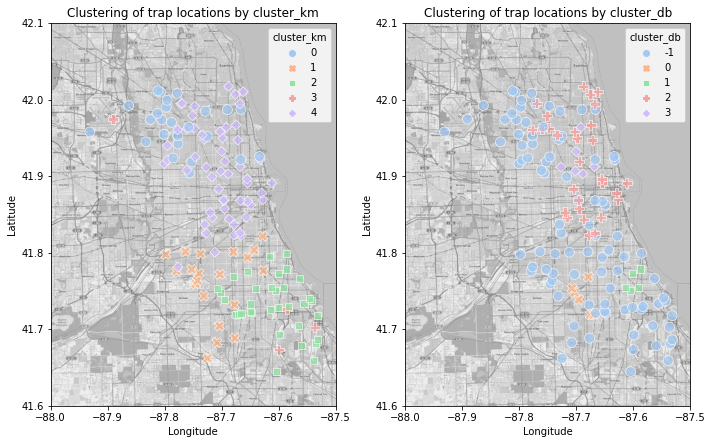

In [82]:
# Plot both map, clustered by KMeans and DBSCAN

mapdata = np.loadtxt("../data/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,14))

clusters = ['cluster_km', 'cluster_db']

for cluster_type, axes in zip(clusters, axes.flat):
  axes.imshow(mapdata, 
            cmap=plt.get_cmap('gray'), 
            extent=lon_lat_box, 
            aspect=aspect)

  sns.scatterplot(
      data = X_clusters,
      x = 'Longitude',
      y = 'Latitude',
      hue = cluster_type,
      style = cluster_type,
      s = 100,
      alpha = 0.7,
      palette = "pastel",
      ax = axes
  );
  plt.tight_layout()
  axes.title.set_text(f'Clustering of trap locations by {cluster_type}')




#### Add features using KMeans

In [83]:
# Create custom function to add clustered neighborhood and drop some columns
def add_cluster(df):
    df_clustered = pd.merge(
        left = df, 
    # right = X_clusters.drop_duplicates(subset = ['Latitude', 'Longitude']),
        right = X_clusters,
        how = 'left',
        on = ['Latitude', 'Longitude']
    ).drop(
        columns = cols_to_drop
    )
    return df_clustered

In [84]:
# Recreate X and Y
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [85]:
## Create X_train_clustered, X_test_clustered, X_clustered, X_kaggle_clustered

# Drops columns
cols_to_drop = [
#  'cluster_km',
 'cluster_db',
#  'Date_month',
 'WnvPresent',
 'NumMosquitos',  
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
]

# Create datasets with mozzie-neighborhood clusters
X_train_clustered = add_cluster(X_train)
X_test_clustered = add_cluster(X_test)
X_clustered = add_cluster(X)
X_kaggle_clustered = add_cluster(X_kaggle)

# Check
print(X_train.shape, X_train_clustered.shape)
print(X_test.shape, X_test_clustered.shape)
print(X.shape, X_clustered.shape)
print(test.shape, X_kaggle_clustered.shape)

(6356, 54) (6356, 31)
(2119, 54) (2119, 31)
(8475, 54) (8475, 31)
(116293, 55) (116293, 32)


In [86]:
# Check X_kaggle for missing values in cluster_km
# to be expected as there are traps in Test that are unseen in Train
X_kaggle_clustered.isnull().sum()

Id                     0
Species                0
Trap                   0
Latitude               0
Longitude              0
                    ... 
WetBulb_lag3           0
PrecipTotal_lag1       0
PrecipTotal_lag2       0
PrecipTotal_lag3       0
cluster_km          9905
Length: 32, dtype: int64

There are 9905 rows in the Kaggle set that couldn't be mapped. This means that those Traps or GPS coordinates were not seen in the train set. We now use KNeighborsClassifier, setting n_neighbors = 1 by Euclidean measurement, to predict which cluster they should belong to.

In [87]:
# Instantiate KNN to fit missing values of cluster_km in Kaggle test set
cluster_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2, # Euclidean
    n_neighbors = 1
)

# Instantiate SS to standardize GPS coordinates
ss = StandardScaler()

# Fit it 
cluster_model.fit(
    ss.fit_transform(X_clusters[['Latitude','Longitude']]), 
    X_clusters['cluster_km']
)

# Check model score, should give near 100% accuracy
cluster_model.score(ss.transform(X_clusters[['Latitude','Longitude']]), X_clusters['cluster_km'])

1.0

In [88]:
# Create predicted values of clusters
X_kaggle_clustered['pred'] = cluster_model.predict(
    ss.transform(X_kaggle_clustered[['Latitude','Longitude']])
)

# Check predictions
X_kaggle_clustered.loc[X_kaggle_clustered['cluster_km'].isnull(),'pred'].unique()

array([1, 4, 2, 0], dtype=int32)

Missing traps seem be to all over the city, no specific area that they are missing from.

In [89]:
# Overwrite missing cluster_km

def replace_cluster(x):
    if np.isnan(x.cluster_km):
        return x.pred
    else:
        return x.cluster_km

# Impute values
X_kaggle_clustered['cluster_km'] = X_kaggle_clustered.apply(lambda x: replace_cluster(x), axis = 1)
# X_kaggle_clustered['cluster_km'] = X_kaggle_clustered.apply(
#     lambda x: x.pred if np.isnan(x.cluster_km) else x.cluster_km
# )

# Check that all missing values are filled with predicted values
X_kaggle_clustered.isnull().sum()

Id                  0
Species             0
Trap                0
Latitude            0
Longitude           0
                   ..
PrecipTotal_lag1    0
PrecipTotal_lag2    0
PrecipTotal_lag3    0
cluster_km          0
pred                0
Length: 33, dtype: int64

In [90]:
# Check again
X_kaggle_clustered.drop(columns = 'pred', inplace = True)
X_kaggle_clustered['cluster_km'].unique()

array([0., 4., 1., 2., 3.])

Good, all values are present

In [91]:
# Drop Longitude and Latitude, in favor of cluster_km
X_train_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_test_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_kaggle_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)

In [92]:
# Check
X_train_clustered

Species  Trap  Date_week  Date_month  Tmax  Tmin   Tavg  \
0             CULEX RESTUANS  T221         25           6  68.0  60.0  64.00   
1             CULEX RESTUANS  T095         28           7  86.5  70.5  78.50   
2     CULEX PIPIENS/RESTUANS  T002         36           9  89.5  65.0  77.25   
3             CULEX RESTUANS  T158         31           8  91.5  69.0  80.25   
4     CULEX PIPIENS/RESTUANS  T069         31           8  91.5  69.0  80.25   
...                      ...   ...        ...         ...   ...   ...    ...   
6351          CULEX RESTUANS  T080         32           8  78.5  67.0  72.75   
6352  CULEX PIPIENS/RESTUANS  T230         35           8  67.0  61.5  64.25   
6353  CULEX PIPIENS/RESTUANS  T039         23           6  60.5  49.0  54.75   
6354  CULEX PIPIENS/RESTUANS  T090         34           8  83.0  60.0  71.50   
6355  CULEX PIPIENS/RESTUANS  T095         35           9  93.0  77.5  85.25   

      DewPoint  WetBulb  PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  \
0         55.5     59.0         0.00       71.5       74.0       89.0   
1         70.5     73.0         0.67       88.5       82.5       86.5   
2         59.5     66.5         0.00       88.0       84.5       80.0   
3         62.5     69.5         0.00       90.0       87.5       85.0   
4         62.5     69.5         0.00       90.0       87.5       85.0   
...        ...      ...          ...        ...        ...        ...   
6351      55.5     62.0         0.00       90.0       84.0       75.5   
6352      60.5     62.0         1.07       72.5       82.5       79.0   
6353      46.5     50.5         0.09       79.0       72.5       79.0   
6354      58.0     63.5         0.00       81.5       91.5       73.5   
6355      69.0     74.0         0.00       93.5       87.5       77.5   

      Tmin_lag1  Tmin_lag2  Tmin_lag3  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
0          62.5       65.0       67.5      67.00      69.50      78.25   
1          70.0       68.0       61.5      79.25      75.25      74.00   
2          65.0       61.5       58.5      76.50      73.00      69.25   
3          68.5       63.5       65.0      79.25      75.50      75.00   
4          68.5       63.5       65.0      79.25      75.50      75.00   
...         ...        ...        ...        ...        ...        ...   
6351       68.5       67.5       60.5      79.25      75.75      68.00   
6352       63.0       60.0       55.5      67.75      71.25      67.25   
6353       51.5       47.0       51.5      65.25      59.75      65.25   
6354       64.5       69.5       64.0      73.00      80.50      68.75   
6355       72.5       65.0       62.5      83.00      76.25      70.00   

      DewPoint_lag1  DewPoint_lag2  DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  \
0              59.5           62.5           70.0          62.5          65.0   
1              66.5           64.0           60.5          71.0          68.0   
2              61.0           56.5           55.5          67.0          63.0   
3              60.5           56.0           56.5          68.0          64.5   
4              60.5           56.0           56.5          68.0          64.5   
...             ...            ...            ...           ...           ...   
6351           67.5           66.5           57.5          71.0          69.5   
6352           63.0           61.0           56.5          64.5          65.0   
6353           53.5           42.0           46.0          57.5          51.0   
6354           59.0           65.0           62.5          64.0          70.0   
6355           70.5           64.0           55.0          75.0          68.5   

      WetBulb_lag3  PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             72.5             0.030             0.020             0.265   
1             66.0             0.000             0.000             0.000   
2             61.5             0.000             0.000             0.000   
3             64.

In [93]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_week', 'Date_month', 'cluster_km']
continuous_cols = [col for col in X_clustered.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train_clustered = mapper.fit_transform(X_train_clustered)
Z_test_clustered = mapper.transform(X_test_clustered)

# Create Z_ data set for Kaggle, refitted based on full train set
Z_clustered = mapper.fit_transform(X_clustered)
Z_kaggle_clustered = mapper.transform(X_kaggle_clustered)

In [94]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train_clustered.columns[:24]
cat_col_names = Z_train_clustered.columns[24:]
print(num_col_names, '\n\n', cat_col_names)

Index(['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmin_lag1', 'Tmin_lag2',
       'Tmin_lag3', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'DewPoint_lag1',
       'DewPoint_lag2', 'DewPoint_lag3', 'WetBulb_lag1', 'WetBulb_lag2',
       'WetBulb_lag3', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3'],
      dtype='object') 

 Index(['Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Trap_T001',
       'Trap_T002', 'Trap_T003', 'Trap_T004',
       ...
       'Date_month_6', 'Date_month_7', 'Date_month_8', 'Date_month_9',
       'Date_month_10', 'cluster_km_0', 'cluster_km_1', 'cluster_km_2',
       'cluster_km_3', 'cluster_km_4'],
      dtype='object', length=172)


In [95]:
# Create column index-numbers of categorical
cat_col_index = list(range(len(num_col_names),len(Z_train_clustered.columns)))

In [96]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_clustered_sm, y_train_sm = sm.fit_resample(Z_train_clustered, y_train)

# Re-instantiate, for Kaggle submission purposes, 
# as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_clustered_sm, y_sm = sm.fit_resample(Z_clustered, y)

CPU times: user 26.6 s, sys: 464 ms, total: 27.1 s
Wall time: 27.5 s


In [97]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [98]:
# Check
Z_train_clustered.shape, Z_train_clustered_sm.shape

((6356, 196), (12026, 196))

In [99]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_clustered_sm = pd.DataFrame(Z_train_clustered_sm, columns = Z_train_clustered.columns)
display(Z_train_clustered_sm)

Z_clustered_sm = pd.DataFrame(Z_clustered_sm, columns = Z_clustered.columns)
display(Z_clustered_sm)

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0     -1.594119 -0.414386 -1.093235 -0.484309 -0.796956    -0.462624   
1      0.609664  0.963762  0.823648  1.405126  1.251968     1.526073   
2      0.967034  0.241875  0.658399  0.019540  0.300682    -0.462624   
3      1.205281  0.766884  1.054996  0.397427  0.739737    -0.462624   
4      1.205281  0.766884  1.054996  0.397427  0.739737    -0.462624   
...         ...       ...       ...       ...       ...          ...   
12021 -0.105076  1.095015  0.493151  1.090220  0.886089     1.110525   
12022 -0.819817 -0.939395 -0.927986 -0.988158 -0.943308    -0.462624   
12023  1.800898  1.291893  1.649890  1.279164  1.544671     0.398156   
12024  1.800898  1.291893  1.649890  1.279164  1.544671     0.398156   
12025  0.311856  0.548555  0.449298  0.181728  0.300682    -0.419943   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -1.208497  -0.785583   1.012977  -0.080830   0.309871   0.670165   
1       0.960578   0.242464   0.714293   0.949019   0.742880  -0.188388   
2       0.896782   0.484358  -0.062284   0.262453  -0.195306  -0.617665   
3       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
4       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
...          ...        ...        ...        ...        ...        ...   
12021   0.386411   0.000571   0.833767   0.262453   0.598543   0.670165   
12022  -1.208497  -1.208897   0.355873  -0.836053  -0.411810   0.741711   
12023   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12024   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12025   0.131226   0.138117   0.194625   0.143985   0.178274  -0.309968   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -0.702205  -0.301769   0.898359       0.031520       0.503113   
1       1.007906   0.496303   0.318206       0.903118       0.700910   
2       0.624004   0.184014  -0.330201       0.218291      -0.288075   
3       1.007906   0.531001   0.454713       0.156034      -0.354008   
4       1.007906   0.531001   0.454713       0.156034      -0.354008   
...          ...        ...        ...            ...            ...   
12021   0.344802   0.288110   0.795979       0.903118      -0.419940   
12022  -1.086108  -0.891648   0.557093      -1.213620      -1.013331   
12023   2.054913   1.918952   1.649146       1.525688       1.623963   
12024   2.054913   1.918952   1.649146       1.525688       1.623963   
12025   0.144980   0.164965  -0.036665      -0.145891      -0.220417   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0           1.447464     -0.267650      0.178948      1.312100   
1           0.207086      1.018090      0.656110      0.314463   
2          -0.445745      0.413036     -0.139160     -0.376209   
3          -0.315179      0.564300      0.099421      0.007498   
4          -0.315179      0.564300      0.099421      0.007498   
...              ...           ...           ...           ...   
12021       1.055765      0.791195     -0.059633      1.005134   
12022       0.664067     -1.250864     -1.013956      0.045868   
12023       1.578030      1.774409      1.849015      1.695806   
12024       1.578030      1.774409      1.849015      1.695806   
12025      -0.200823      0.002746     -0.001935     -0.143975   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.336896         -0.363120          0.722332   
1             -0.418017         -0.399946         -0.426461   
2             -0.418017         -0.399946         -0.426461   
3             -0.418017         -0.399946         -0.426461   
4             -0.418017         -0.399946         -0.426461   
...                 ...               ...               ...   
12021          0.744724         -0.399946          0.700657   
12022         -0.418017         -0.399946          1.589346   
12023         -0.418

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
1      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
2      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
3      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
4      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
...         ...       ...       ...       ...       ...          ...   
16031 -0.811800 -0.923190 -0.915736 -0.973304 -0.930033    -0.458229   
16032 -0.335362  0.515172  0.074195 -0.470806 -0.345757    -0.458229   
16033  0.915289  1.299733  1.163120  0.911063  0.968864    -0.443508   
16034 -0.394917  0.580552  0.074195  0.911063  0.603691     0.410304   
16035  0.557960  0.776692  0.701152  1.350748  1.114933    -0.443508   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
1      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
2      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
3      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
4      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
...          ...        ...        ...        ...        ...        ...   
16031  -1.199350  -1.197616   0.365025  -0.821002  -0.395151   0.749587   
16032   1.157612   0.427709  -0.587727   0.751008   0.679939  -0.313314   
16033   0.775402   0.788893   1.615511   1.229446   1.038302   1.103887   
16034   1.221313   0.909287   0.603212   0.819356   0.608266  -0.384174   
16035  -0.498632  -1.438405  -1.421384   0.682660  -0.108460  -0.455035   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
1      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
2      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
3      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
4      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
...          ...        ...        ...            ...            ...   
16031  -1.071525  -0.876593   0.566563      -1.190820      -0.999256   
16032   1.013178   0.572427  -0.484610       1.036642       1.038131   
16033   1.047923   0.951932   1.448193       1.284138       1.498187   
16034   1.082668   0.813930   0.159658       0.665399       0.380910   
16035   0.075062  -0.876593  -1.027151       1.160390       0.512354   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0          -0.488253     -1.155019     -1.155982     -1.118044   
1          -0.488253     -1.155019     -1.155982     -1.118044   
2          -0.488253     -1.155019     -1.155982     -1.118044   
3          -0.488253     -1.155019     -1.155982     -1.118044   
4          -0.488253     -1.155019     -1.155982     -1.118044   
...              ...           ...           ...           ...   
16031       0.673782     -1.230235     -0.997788      0.061149   
16032      -0.165465      1.026250      0.900538     -0.357274   
16033       1.448473      1.251899      1.454217      1.468572   
16034       0.028207      0.875818      0.584151      0.175264   
16035      -0.617368      0.800602      0.030472     -0.889813   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.416099         -0.288426          2.367833   
1             -0.416099         -0.288426          2.367833   
2             -0.416099         -0.288426          2.367833   
3             -0.416099         -0.288426          2.367833   
4             -0.416099         -0.288426          2.367833   
...                 ...               ...               ...   
16031         -0.416099         -0.399509          1.588289   
16032         -0.402759         -0.362481         -0.230646   
16033         -0.149

We have now finished preparing the data with clustered neighborhoods and dropping longitude/latitude coordinates. Time to see if the model performs better!

#### Logistic Regression

In [100]:
%%time
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}


# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 11}
CPU times: user 385 ms, sys: 111 ms, total: 496 ms
Wall time: 5.08 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845          NaN   

  Runtime (sec)                             Remarks  
0             7                                 NaN  
0            24                                 NaN  
0            33                                 NaN  
0            93                                 NaN  
0           136                                 NaN  
0           133                                 NaN  
0           176  Cousin of Model 1, a lot of tuning  
0           104  Cousin of Model 6, a lot of tuning  
0            10   Drop month, weather lagged 7 days  
0           182   Drop month, weather lagged 7 days  
0             6   Drop month, weather lagged 3 days  
0           141   Drop month, weather lagged 3 days  
0             4    Drop month, weather lagged 1 day  
0           114    Drop month, weather lagged 1 day  
0             5                                 NaN

When compared to Model 11, which is the better performing logistic regression model to date, Model 15 outperforms in every area! This is a positive development.

In [101]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 8}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 8
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_15.csv', index=False)

Training ROC AUC: 0.993


In [102]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 15, 'Kaggle Score'] = 0.708
df_results.loc[df_results['Model No.'] == 15, 'Remarks'] = 'Cousin of Model 11, with KMeans mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters

Kaggle score is lower than Model 11, but given that all other metrics are better, we shall reserve judgement until we see how it works for XGBoost.

#### XGBoost

In [103]:
%%time
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:53:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 0.75, 'max_depth': 7, 'learning_rate': 0.5}
CPU times: user 20 s, sys: 631 ms, total: 20.6 s
Wall time: 1min 57s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   
0        16  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   
0             0.990            0.997           0.829          NaN   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters  
0           118                                              NaN

All the scores for Model 16 have comparable results to Model 12 which is the best to date model for XGBoost.

In [104]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 7, 'learning_rate': 0.3}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 7, 
    learning_rate = 0.3                      
)


# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_16.csv', index=False)

[12:53:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.995


In [105]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 16, 'Kaggle Score'] = 0.69
df_results.loc[df_results['Model No.'] == 16, 'Remarks'] = 'Cousin of Model 12, with KMeans mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   
0        16  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   
0             0.990            0.997           0.829         0.69   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters  
0           118  Cousin of Model 12, with KMeans mozzie clusters

With lower Kaggle score than Model 12, XGBoost also did not get a better results just like Logistic Regression. Hence, we proceed to test it out with DBSCAN which is a better clustering method than Kmeans Clustering to decide whether to include the clusters for prediction.

### Step 7 (DBSCAN)

In this section, we repeat what we did in earlier, except that we use a different algorithm DBSCAN to come up with mosquito clusters.


In the subsequent sections, we will create mozzie 'clusters' by using 4 variables: `   'Latitude', 'Longitude', 'WnvPresent', 'NumMosquitos'`. DSCAN algorithm will be used to assign cluster values based on proximity to these 4 variables. As seen earlier, the Kaggle test has Trap IDs and/or Longitude-Latitude coordinates that are not seen in the train set. For these locations, we will use KNeighborsClassifer to predict which mozzie cluster they should belong to.

In [106]:
# Must bring back Latitude, as it was dropped earlier
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [107]:
## Create X_train_clustered, X_test_clustered, X_clustered, X_kaggle_clustered

# Drops columns: cluster_db + others mentioned for Model 8
cols_to_drop = [
 'cluster_km',
#  'cluster_db',
#  'Date_month',
 'WnvPresent',
 'NumMosquitos',  
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
]

# Create datasets with mozzie-neighborhood clusters
X_train_clustered = add_cluster(X_train)
X_test_clustered = add_cluster(X_test)
X_clustered = add_cluster(X)
X_kaggle_clustered = add_cluster(X_kaggle)

# Check
print(X_train.shape, X_train_clustered.shape)
print(X_test.shape, X_test_clustered.shape)
print(X.shape, X_clustered.shape)
print(test.shape, X_kaggle_clustered.shape)

(6356, 54) (6356, 31)
(2119, 54) (2119, 31)
(8475, 54) (8475, 31)
(116293, 55) (116293, 32)


In [108]:
# Check X_kaggle for missing values in cluster_km
# to be expected as there are traps in Test that are unseen in Train
X_kaggle_clustered.isnull().sum()

Id                     0
Species                0
Trap                   0
Latitude               0
Longitude              0
                    ... 
WetBulb_lag3           0
PrecipTotal_lag1       0
PrecipTotal_lag2       0
PrecipTotal_lag3       0
cluster_db          9905
Length: 32, dtype: int64

There are 9905 rows in the Kaggle set that couldn't be mapped. This means that those Traps or GPS coordinates were not seen in the train set. We now use KNeighborsClassifier, setting n_neighbors = 1 by Euclidean measurement, to predict which cluster they should belong to.

In [109]:
# Instantiate KNN to fit missing values of cluster_km in Kaggle test set
cluster_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2, # Euclidean
    n_neighbors = 1
)

# Instantiate SS to standardize GPS coordinates
ss = StandardScaler()

# Fit it 
cluster_model.fit(
    ss.fit_transform(X_clusters[['Latitude','Longitude']]), 
    X_clusters['cluster_db']
)

# Check model score, should give near 100% accuracy
cluster_model.score(ss.transform(X_clusters[['Latitude','Longitude']]), X_clusters['cluster_db'])

1.0

In [110]:
# Create predicted values of clusters
X_kaggle_clustered['pred'] = cluster_model.predict(
    ss.transform(X_kaggle_clustered[['Latitude','Longitude']])
)

# Check predictions
X_kaggle_clustered.loc[X_kaggle_clustered['cluster_db'].isnull(),'pred'].unique()

array([-1,  2])

DBSCAN clusters '-1' and '2' are found all over the city, no specific area that they are missing from.

In [111]:
# Overwrite missing cluster_km
def replace_cluster(x):
    if np.isnan(x.cluster_db):
        return x.pred
    else:
        return x.cluster_db

# Impute values
X_kaggle_clustered['cluster_db'] = X_kaggle_clustered.apply(lambda x: replace_cluster(x), axis = 1)

# Check
X_kaggle_clustered.isnull().sum()

Id                  0
Species             0
Trap                0
Latitude            0
Longitude           0
                   ..
PrecipTotal_lag1    0
PrecipTotal_lag2    0
PrecipTotal_lag3    0
cluster_db          0
pred                0
Length: 33, dtype: int64

In [112]:
# Check again
X_kaggle_clustered.drop(columns = 'pred', inplace = True)
X_kaggle_clustered['cluster_db'].unique()

array([-1.,  2.,  3.,  0.,  1.])

In [113]:
# Drop Longitude and Latitude, in favor of cluster_km
X_train_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_test_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_kaggle_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)

In [114]:
# Check
X_clustered

Species  Trap  Date_week  Date_month  Tmax  Tmin   Tavg  \
0              CULEX PIPIENS  T096         22           5  88.0  62.5  75.25   
1     CULEX PIPIENS/RESTUANS  T002         22           5  88.0  62.5  75.25   
2     CULEX PIPIENS/RESTUANS  T015         22           5  88.0  62.5  75.25   
3     CULEX PIPIENS/RESTUANS  T048         22           5  88.0  62.5  75.25   
4     CULEX PIPIENS/RESTUANS  T050         22           5  88.0  62.5  75.25   
...                      ...   ...        ...         ...   ...   ...    ...   
8470          CULEX RESTUANS  T082         39           9  75.0  52.5  63.75   
8471          CULEX RESTUANS  T102         39           9  75.0  52.5  63.75   
8472          CULEX RESTUANS  T209         39           9  75.0  52.5  63.75   
8473          CULEX RESTUANS  T220         39           9  75.0  52.5  63.75   
8474          CULEX RESTUANS  T221         39           9  75.0  52.5  63.75   

      DewPoint  WetBulb  PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  \
0         58.5     65.5          0.0       77.5       75.0       67.5   
1         58.5     65.5          0.0       77.5       75.0       67.5   
2         58.5     65.5          0.0       77.5       75.0       67.5   
3         58.5     65.5          0.0       77.5       75.0       67.5   
4         58.5     65.5          0.0       77.5       75.0       67.5   
...        ...      ...          ...        ...        ...        ...   
8470      52.0     58.0          0.0       70.5       80.5       67.0   
8471      52.0     58.0          0.0       70.5       80.5       67.0   
8472      52.0     58.0          0.0       70.5       80.5       67.0   
8473      52.0     58.0          0.0       70.5       80.5       67.0   
8474      52.0     58.0          0.0       70.5       80.5       67.0   

      Tmin_lag1  Tmin_lag2  Tmin_lag3  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
0          52.0       58.0       49.5      64.75       66.5       58.5   
1          52.0       58.0       49.5      64.75       66.5       58.5   
2          52.0       58.0       49.5      64.75       66.5       58.5   
3          52.0       58.0       49.5      64.75       66.5       58.5   
4          52.0       58.0       49.5      64.75       66.5       58.5   
...         ...        ...        ...        ...        ...        ...   
8470       53.5       50.5       48.0      62.00       65.5       57.5   
8471       53.5       50.5       48.0      62.00       65.5       57.5   
8472       53.5       50.5       48.0      62.00       65.5       57.5   
8473       53.5       50.5       48.0      62.00       65.5       57.5   
8474       53.5       50.5       48.0      62.00       65.5       57.5   

      DewPoint_lag1  DewPoint_lag2  DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  \
0              48.0           48.0           55.0          56.5          56.5   
1              48.0           48.0           55.0          56.5          56.5   
2              48.0           48.0           55.0          56.5          56.5   
3              48.0           48.0           55.0          56.5          56.5   
4              48.0           48.0           55.0          56.5          56.5   
...             ...            ...            ...           ...           ...   
8470           51.5           48.5           46.5          56.0          54.0   
8471           51.5           48.5           46.5          56.0          54.0   
8472           51.5           48.5           46.5          56.0          54.0   
8473           51.5           48.5           46.5          56.0          54.0   
8474           51.5           48.5           46.5          56.0          54.0   

      WetBulb_lag3  PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             56.5               0.0              0.06             0.645   
1             56.5               0.0              0.06             0.645   
2             56.5               0.0              0.06             0.645   
3             56.

In [115]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_week', 'Date_month', 'cluster_db']
continuous_cols = [col for col in X_clustered.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train_clustered = mapper.fit_transform(X_train_clustered)
Z_test_clustered = mapper.transform(X_test_clustered)

# Create Z_ data set for Kaggle, refitted based on full train set
Z_clustered = mapper.fit_transform(X_clustered)
Z_kaggle_clustered = mapper.transform(X_kaggle_clustered)

In [116]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train_clustered.columns[:24]
cat_col_names = Z_train_clustered.columns[24:]
print(num_col_names, '\n\n', cat_col_names)

Index(['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmin_lag1', 'Tmin_lag2',
       'Tmin_lag3', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'DewPoint_lag1',
       'DewPoint_lag2', 'DewPoint_lag3', 'WetBulb_lag1', 'WetBulb_lag2',
       'WetBulb_lag3', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3'],
      dtype='object') 

 Index(['Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Trap_T001',
       'Trap_T002', 'Trap_T003', 'Trap_T004',
       ...
       'Date_month_6', 'Date_month_7', 'Date_month_8', 'Date_month_9',
       'Date_month_10', 'cluster_db_-1', 'cluster_db_0', 'cluster_db_1',
       'cluster_db_2', 'cluster_db_3'],
      dtype='object', length=172)


In [117]:
# Create column index-numbers of categorical
cat_col_index = list(range(len(num_col_names),len(Z_train_clustered.columns)))

In [118]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_clustered_sm, y_train_sm = sm.fit_resample(Z_train_clustered, y_train)

# Re-instantiate, for Kaggle submission purposes, 
# as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_clustered_sm, y_sm = sm.fit_resample(Z_clustered, y)

CPU times: user 26 s, sys: 305 ms, total: 26.3 s
Wall time: 26.4 s


In [119]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [120]:
# Check
Z_train_clustered.shape, Z_train_clustered_sm.shape

((6356, 196), (12026, 196))

In [121]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_clustered_sm = pd.DataFrame(Z_train_clustered_sm, columns = Z_train_clustered.columns)
display(Z_train_clustered_sm)

Z_clustered_sm = pd.DataFrame(Z_clustered_sm, columns = Z_clustered.columns)
display(Z_clustered_sm)

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0     -1.594119 -0.414386 -1.093235 -0.484309 -0.796956    -0.462624   
1      0.609664  0.963762  0.823648  1.405126  1.251968     1.526073   
2      0.967034  0.241875  0.658399  0.019540  0.300682    -0.462624   
3      1.205281  0.766884  1.054996  0.397427  0.739737    -0.462624   
4      1.205281  0.766884  1.054996  0.397427  0.739737    -0.462624   
...         ...       ...       ...       ...       ...          ...   
12021 -0.105076  1.095015  0.493151  1.090220  0.886089     1.110525   
12022 -0.819817 -0.939395 -0.927986 -0.988158 -0.943308    -0.462624   
12023  1.800898  1.291893  1.649890  1.279164  1.544671     0.398156   
12024  1.800898  1.291893  1.649890  1.279164  1.544671     0.398156   
12025  0.311856  0.548555  0.449298  0.181728  0.300682    -0.419943   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -1.208497  -0.785583   1.012977  -0.080830   0.309871   0.670165   
1       0.960578   0.242464   0.714293   0.949019   0.742880  -0.188388   
2       0.896782   0.484358  -0.062284   0.262453  -0.195306  -0.617665   
3       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
4       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
...          ...        ...        ...        ...        ...        ...   
12021   0.386411   0.000571   0.833767   0.262453   0.598543   0.670165   
12022  -1.208497  -1.208897   0.355873  -0.836053  -0.411810   0.741711   
12023   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12024   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12025   0.131226   0.138117   0.194625   0.143985   0.178274  -0.309968   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -0.702205  -0.301769   0.898359       0.031520       0.503113   
1       1.007906   0.496303   0.318206       0.903118       0.700910   
2       0.624004   0.184014  -0.330201       0.218291      -0.288075   
3       1.007906   0.531001   0.454713       0.156034      -0.354008   
4       1.007906   0.531001   0.454713       0.156034      -0.354008   
...          ...        ...        ...            ...            ...   
12021   0.344802   0.288110   0.795979       0.903118      -0.419940   
12022  -1.086108  -0.891648   0.557093      -1.213620      -1.013331   
12023   2.054913   1.918952   1.649146       1.525688       1.623963   
12024   2.054913   1.918952   1.649146       1.525688       1.623963   
12025   0.144980   0.164965  -0.036665      -0.145891      -0.220417   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0           1.447464     -0.267650      0.178948      1.312100   
1           0.207086      1.018090      0.656110      0.314463   
2          -0.445745      0.413036     -0.139160     -0.376209   
3          -0.315179      0.564300      0.099421      0.007498   
4          -0.315179      0.564300      0.099421      0.007498   
...              ...           ...           ...           ...   
12021       1.055765      0.791195     -0.059633      1.005134   
12022       0.664067     -1.250864     -1.013956      0.045868   
12023       1.578030      1.774409      1.849015      1.695806   
12024       1.578030      1.774409      1.849015      1.695806   
12025      -0.200823      0.002746     -0.001935     -0.143975   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.336896         -0.363120          0.722332   
1             -0.418017         -0.399946         -0.426461   
2             -0.418017         -0.399946         -0.426461   
3             -0.418017         -0.399946         -0.426461   
4             -0.418017         -0.399946         -0.426461   
...                 ...               ...               ...   
12021          0.744724         -0.399946          0.700657   
12022         -0.418017         -0.399946          1.589346   
12023         -0.418

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
1      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
2      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
3      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
4      0.796179 -0.073249  0.404172 -0.093933  0.165484    -0.458229   
...         ...       ...       ...       ...       ...          ...   
16031 -0.811800 -0.923190 -0.915736 -0.973304 -0.930033    -0.458229   
16032 -0.335362  0.515172  0.074195 -0.470806 -0.345757    -0.458229   
16033  0.915289  1.299733  1.163120  0.911063  0.968864    -0.443508   
16034 -0.394917  0.580552  0.074195  0.911063  0.603691     0.410304   
16035  0.557960  0.776692  0.701152  1.350748  1.114933    -0.443508   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
1      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
2      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
3      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
4      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
...          ...        ...        ...        ...        ...        ...   
16031  -1.199350  -1.197616   0.365025  -0.821002  -0.395151   0.749587   
16032   1.157612   0.427709  -0.587727   0.751008   0.679939  -0.313314   
16033   0.775402   0.788893   1.615511   1.229446   1.038302   1.103887   
16034   1.221313   0.909287   0.603212   0.819356   0.608266  -0.384174   
16035  -0.498632  -1.438405  -1.421384   0.682660  -0.108460  -0.455035   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
1      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
2      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
3      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
4      -1.002035  -0.704091  -1.773145      -1.376441      -1.393590   
...          ...        ...        ...            ...            ...   
16031  -1.071525  -0.876593   0.566563      -1.190820      -0.999256   
16032   1.013178   0.572427  -0.484610       1.036642       1.038131   
16033   1.047923   0.951932   1.448193       1.284138       1.498187   
16034   1.082668   0.813930   0.159658       0.665399       0.380910   
16035   0.075062  -0.876593  -1.027151       1.160390       0.512354   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0          -0.488253     -1.155019     -1.155982     -1.118044   
1          -0.488253     -1.155019     -1.155982     -1.118044   
2          -0.488253     -1.155019     -1.155982     -1.118044   
3          -0.488253     -1.155019     -1.155982     -1.118044   
4          -0.488253     -1.155019     -1.155982     -1.118044   
...              ...           ...           ...           ...   
16031       0.673782     -1.230235     -0.997788      0.061149   
16032      -0.165465      1.026250      0.900538     -0.357274   
16033       1.448473      1.251899      1.454217      1.468572   
16034       0.028207      0.875818      0.584151      0.175264   
16035      -0.617368      0.800602      0.030472     -0.889813   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.416099         -0.288426          2.367833   
1             -0.416099         -0.288426          2.367833   
2             -0.416099         -0.288426          2.367833   
3             -0.416099         -0.288426          2.367833   
4             -0.416099         -0.288426          2.367833   
...                 ...               ...               ...   
16031         -0.416099         -0.399509          1.588289   
16032         -0.402759         -0.362481         -0.230646   
16033         -0.149

#### Logistic Regression

In [122]:
%%time
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [1, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20],
    'max_iter': [10_000]
}


# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 7}
CPU times: user 366 ms, sys: 125 ms, total: 491 ms
Wall time: 9.41 s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   
0        16  XGBClassifier(base_score=None, booster=None, c...   
0        17  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   
0             0.990            0.997           0.829         0.69   
0             0.990            0.994           0.849          NaN   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters  
0           118  Cousin of Model 12, with KMeans mozzie clusters  
0             9                                              NaN

DBSCAN clustering allows us to beat Model 11 on all metrics (average CV score, train ROC_AUC score, test ROC_AUC score) as well as Model 15 which uses the Kmeans clustering algorithm. It looks like DBSCAN could be a better algorithm for mapping mozzie zones.

In [123]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_17.csv', index=False)

Training ROC AUC: 0.993


In [124]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 17, 'Kaggle Score'] = 0.725
df_results.loc[df_results['Model No.'] == 17, 'Remarks'] = 'Cousin of Model 11, with DBSCAN mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   
0        16  XGBClassifier(base_score=None, booster=None, c...   
0        17  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   
0             0.990            0.997           0.829         0.69   
0             0.990            0.994           0.849        0.725   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters  
0           118  Cousin of Model 12, with KMeans mozzie clusters  
0             9  Cousin of Model 11, with DBSCAN mozzie clusters

Model 17 is the best logistic model to date, which highest scores in all categories. DBSCAN is a better clustering algorithm than KMeans, which is in turn better than using plain GPS coordinates. 

#### XGBoost

In [125]:
%%time
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
    'max_depth' : [1, 3, 5, 7, 9, 11, 13, 15, None], 
    'subsample' : [0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[12:56:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 1, 'max_depth': 11, 'learning_rate': 0.9}
CPU times: user 29.6 s, sys: 751 ms, total: 30.3 s
Wall time: 2min 9s


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   
0        16  XGBClassifier(base_score=None, booster=None, c...   
0        17  LogisticRegression(random_state=42, solver='li...   
0        18  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   
0             0.990            0.997           0.829         0.69   
0             0.990            0.994           0.849        0.725   
0             0.991            0.999           0.843          NaN   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters  
0           118  Cousin of Model 12, with KMeans mozzie clusters  
0             9  Cousin of Model 11, with DBSCAN mozzie clusters  
0           129                                              NaN

After using DBSCAN for the clustering, Model 18's performance improve for the test ROC_AUC score from Model 16 (0.828 to 0.841). This means that the DBSCAN clustering indeed is a better clustering algorithm than Kmeans clustering.

In [126]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'max_depth': 13, 'learning_rate': 0.7}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 13, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
kaggle.to_csv('../data/project4_model_18.csv', index=False)

[12:56:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.999


In [127]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 18, 'Kaggle Score'] = 0.704
df_results.loc[df_results['Model No.'] == 18, 'Remarks'] = 'Cousin of Model 12, with DBSCAN mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4              ExtraTreesClassifier(random_state=42)   
0         5               SVC(max_iter=10000, random_state=42)   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  XGBClassifier(base_score=None, booster=None, c...   
0         9  LogisticRegression(random_state=42, solver='li...   
0        10  XGBClassifier(base_score=None, booster=None, c...   
0        11  LogisticRegression(random_state=42, solver='li...   
0        12  XGBClassifier(base_score=None, booster=None, c...   
0        13  LogisticRegression(random_state=42, solver='li...   
0        14  XGBClassifier(base_score=None, booster=None, c...   
0        15  LogisticRegression(random_state=42, solver='li...   
0        16  XGBClassifier(base_score=None, booster=None, c...   
0        17  LogisticRegression(random_state=42, solver='li...   
0        18  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.830        0.684   
0             0.919            1.000           0.776        0.596   
0             0.979            0.996           0.804        0.643   
0             0.989            1.000           0.809         0.71   
0             0.973            0.981           0.803        0.598   
0             0.992            1.000           0.831        0.697   
0             0.989            0.994           0.828        0.684   
0             0.991            0.999           0.830        0.658   
0             0.989            0.994           0.826        0.693   
0             0.990            1.000           0.797        0.673   
0             0.988            0.993           0.832        0.717   
0             0.990            0.997           0.826        0.683   
0             0.987            0.992           0.826        0.734   
0             0.992            0.999           0.825        0.715   
0             0.989            0.993           0.845        0.708   
0             0.990            0.997           0.829         0.69   
0             0.990            0.994           0.849        0.725   
0             0.991            0.999           0.843        0.704   

  Runtime (sec)                                          Remarks  
0             7                                              NaN  
0            24                                              NaN  
0            33                                              NaN  
0            93                                              NaN  
0           136                                              NaN  
0           133                                              NaN  
0           176               Cousin of Model 1, a lot of tuning  
0           104               Cousin of Model 6, a lot of tuning  
0            10                Drop month, weather lagged 7 days  
0           182                Drop month, weather lagged 7 days  
0             6                Drop month, weather lagged 3 days  
0           141                Drop month, weather lagged 3 days  
0             4                 Drop month, weather lagged 1 day  
0           114                 Drop month, weather lagged 1 day  
0             5  Cousin of Model 11, with KMeans mozzie clusters  
0           118  Cousin of Model 12, with KMeans mozzie clusters  
0             9  Cousin of Model 11, with DBSCAN mozzie clusters  
0           129  Cousin of Model 12, with DBSCAN mozzie clusters

Model 18 is the best XGBoost model to date, which one of the highest scores in all categories. Hence, DBSCAN seems to be superior to KMeans in creating mozzie clusters. 

In [128]:
# Highlight rows in df_results but can't get it to work...
def color_df(x):
    c1 = 'background-color: cyan'
    c2 = 'background-color: yellow'
    c3 = 'background-color: green'
    c4 = 'background-color: blue'
    c5 = 'background-color: orange'
    c6 = 'background-color: cyan'
    c7 = 'background-color: yellow'
    df = x.copy()
    # Select rows to mask
    mask1 = x['Model No.'].isin([1,2,3,4,5,6])
    mask2 = x['Model No.'].isin([7,8])
    mask3 = x['Model No.'].isin([9,10])
    mask4 = x['Model No.'].isin([11,12])
    mask5 = x['Model No.'].isin([13,14])
    mask6 = x['Model No.'].isin([15,16])
    mask7 = x['Model No.'].isin([17,18])
    # Input mask to dataframe
    df.loc[mask1,:] = c1
    df.loc[mask2,:] = c2
    df.loc[mask3,:] = c3
    df.loc[mask4,:] = c4
    df.loc[mask5,:] = c5
    df.loc[mask6,:] = c6
    df.loc[mask7,:] = c7
    return df

df_results = df_results.reset_index(drop = True)
df_results.style.apply(color_df, axis = None)

### Selected model

We have gone through a long journey where we started with an initial spread of 6 baseline models, then taking the 2 best models to finetune their hyperparameters intensely (without too much success), then trying to drop some features which we thought were too correlated. Dropping worked for some correlated features but not for others, namely:
- Even though `month of the year` is correlated to `week of the year`, dropping the former reduces scores uniformly, meaning that the predictive value of `month` outweighs its high correlation to `week`.
- Lagged weather values, namely `temperature, dew point, wet bulb, precipitation`, are introduced to account for the life cycle of mosquitoes, on the assumption that mosquitoes breed better after certain ideal weather conditions are met. However, the downside is that lagged weather values suffer from autocorrelation, meaning that if the temperature is hot today, it is likely to be hot yesterday too or if it humid today, it is likely to be humid yesterday. So, while we started with 7 lagged values for each weather variable as that is the breeding cycle of a mosquito, we dropped lag=4,5,6,7 to find out it improves performance. However, when we dropped lag=2,3, performance deteoriates as too much predictive value is lost. We stop at lag = 3 for our final model.
- We then replaced `Latitude, Longitutde` with engineered features on the assumption that GPS coordinates are too crude to proxy for likely mosquito breeding locations. Instead, we make use of clustering algorithms to help us decide which parts of Chicago have historically been high breeding neighborhoods for mosquitos (using `NumMosquitos` as variable) and for the presence of West Nile Virus (using `WnvPresent` as variable). We found that using DBSCAN is better than KMeans.

Finally, the best two models are Logistic Regression which is a parametric model (Model 17), and XGBoost Classifier which is a non-parametric supervised model (Model 18). Logistic regression is a simpler model for end-users such as city officials to understand. It also happens to give better AUC-ROC scores for us, which is the Kaggle criteria for winning the competition. 

However, we think it is still better to look at other traditional metrics, such as accuracy, sensitivity, specificity and precision. In particular, sensitivity is important because Chicago city officials might make expensive decisions on mosquito-eradication methods (spray in areas we predict to be positive, and don't spray in areas we predict to be negative). Therefore it is also important to have as high true positive as possible, and as low false negative as possible. This points to using sensitivity as a secondary metric for us to use as assessment since AUC_ROC is quite close between Models 17 and 18.

Accuracy: 0.9452571967909391 
 Sensitivity: 0.044 
 Specificity: 0.997 
 Precision: 0.417 
 Tesst ROC AUC: 0.849


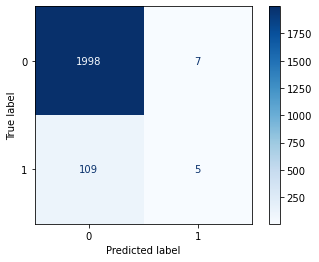

In [129]:
# Check confusion matrix for Model 17
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_train_clustered_sm, y_train_sm)
# Predict
y_pred = best_model.predict(Z_test_clustered)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plot_confusion_matrix(best_model, 
                      Z_test_clustered, y_test, 
                      cmap='Blues', 
                      values_format='d', 
                     )
final_auc = roc_auc_score(y_true = y_test, y_score = best_model.predict_proba(Z_test_clustered)[:,1])

print(f'Accuracy: {(tn+tp)/(tn+tp+fn+fp)} \
\n Sensitivity: {tp/(tp+fn):.3f} \
\n Specificity: {tn/(tn+fp):.3f} \
\n Precision: {tp/(tp+fp):.3f} \
\n Tesst ROC AUC: {final_auc:.3f}')


# # Plot ROC curve
# plot_roc_curve(best_model, Z_test_clustered, y_test)
# # add worst case scenario line
# plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")
# # add title
# plt.title('Receiver Operating Characteristic (ROC) Curve');

It is evident that despite its high ROC_AUC score, Logistic Regression (Model 17) is still strongly preferring to predict negatives in all but 12 cases in the validation set. That is not very helpful to policy makers. True positives are very low (5), and the false negatives are quite high (109). Let's check if XGBoost (Model 18) takes the lazy way out like Logistic Regression.

[12:56:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9211892402076451 
 Sensitivity: 0.254 
 Specificity: 0.959 
 Precision: 0.261 
 Test ROC AUC: 0.841


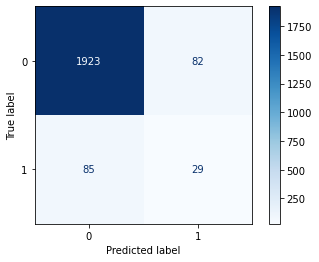

In [130]:
# Check confusion matrix for Model 18
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    max_depth = 13, 
    learning_rate = 0.7                      
)

# Fit it 
best_model.fit(Z_train_clustered_sm, y_train_sm)
# Predict
y_pred = best_model.predict(Z_test_clustered)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

plot_confusion_matrix(best_model, 
                      Z_test_clustered, y_test, 
                      cmap='Blues', 
                      values_format='d', 
                     );
final_auc = roc_auc_score(y_true = y_test, y_score = best_model.predict_proba(Z_test_clustered)[:,1])

print(f'Accuracy: {(tn+tp)/(tn+tp+fn+fp)} \
\n Sensitivity: {tp/(tp+fn):.3f} \
\n Specificity: {tn/(tn+fp):.3f} \
\n Precision: {tp/(tp+fp):.3f} \
\n Test ROC AUC: {final_auc:.3f}')


# # Plot ROC curve
# plot_roc_curve(best_model, Z_test_clustered, y_test)
# # add worst case scenario line
# plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")
# # add title
# plt.title('Receiver Operating Characteristic (ROC) Curve');

This is more promising. XGBoost (Model 18) bravely puts 111 predictions as positive, as compared to Model 17 predicting only a measly 12 positive cases. As such, Model 18's sensitivity score is 0.254, which is 477% higher than Model 17's 0.044. 

Considering that:
- Model 18's AUC_ROC score for the test set is marginally lower at 0.841 compared to Model 17's 0.849, 
- Model 18's AUC_ROC Kaggle score is marginally lower at 0.704 compared to Model 17's 0.725, 
- BUT Model 18's sensitivity is much higher at 0.254, versus Model 17's 0.044
we will go with Model 18 as our final selected model.

In [131]:
82+29

111

In [132]:
0.254 / 0.044 - 1

4.772727272727273

### Features of importance

In [133]:
len(best_model.feature_importances_)

196

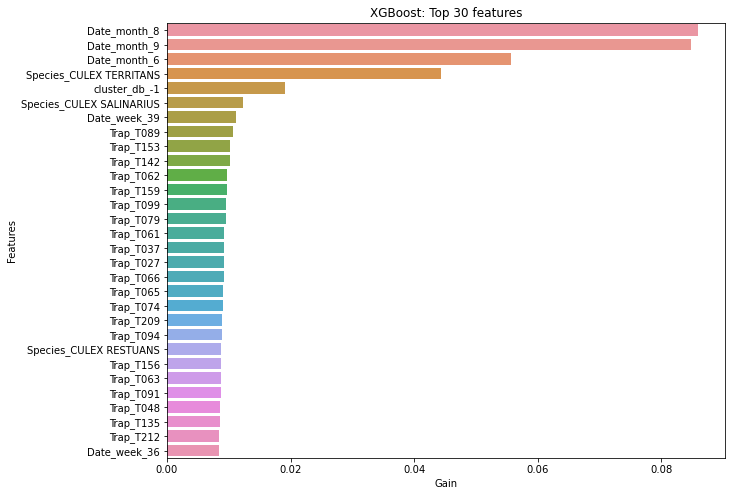

In [134]:
# Obtain coefficients from logit model
feature_values = best_model.feature_importances_

# Obtain feature names from TF-IDF vectorizer
feature_names = Z_train_clustered_sm.columns

# Create dataframe of features and their coefficients
df_gini = pd.DataFrame(zip(feature_names, feature_values), 
                       columns = ["Features", "Gain"]
                      ).sort_values('Gain', 
                                    ascending = False)

# Plot 20 highest features
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'Gain', y = 'Features', data = df_gini.head(30))
ax.set_title(f"XGBoost: Top 30 features")
ax.set_xlabel("Gain")
ax.set_ylabel("Features");

In XGBoost, the default metric for feature importance is "gain", which is defined as the average gain across all splits the feature is used in, where a gain is the improvement in AUC_ROC score brought by a feature to the branches it is on. 

We make the following observations:
- Month: The month of the year is the most important predictor for WNV cases. August has the highest importance, followed by September, then June. They are responsible for improving AUC_ROC scores by 0.2.
- Species: Mosquito species is the next most important feature, with Culex Territans the highest followed by Culex Salinarius. They are responsible for improving AUC_ROC scores by close to 0.05 and 0.02 respectively. 
- Cluster: DBSCAN's `Cluster -1` has strong predictive value. This cluster is mainly located in the Northwest and Southwest of the city. It is responsible for improving AUC_ROC score by 0.025.
- Week: The 39th week of the year is next in line of importance. This falls within the hot summer period of the year.
- Trap: Finally, trap IDs are the next feature of importances. Trap 086, 151 and 142 are most important.
- Weather: Interestingly, we do not see any weather-related features in the Top 30 chart, lagged or unlagged. 

## Summary

1. While a simpler parametric model like Logistic Regression with high AUC_ROC scores may be more appealing to end-users, the inability to weave complex non-linear interactions may result the model in choosing simple solutions to solving complex problems such as predicting virus locations. As seen in Model 17, it assigns WNV-negative predictions to 99.4% of the test set. This allows it to achieve a higher AUC_ROC score than all tested models (XGBoost, Random Forest, Extra Trees, Support Vector Machines, KNeighbors). However, its sensitivity is a measly 0.044, which means its usefulness to the government may be limited.
2. On the other hand, a non-parametric supervised learning model such as XGBoost may be able to deal with an unbalanced data set. This is shown in Model 18, where it 'bravely' predicts 94.8% WNV-negative cases, which is quite true to the 'negative' proportions seen in the original dataset before SMOTE-ing. Its AUC_ROC score is lower than a simple model like Logistic Regression, but it has a much higher sensitivity at 0.254, which means it may be a more use-able project for city officials in deciding where to spray and tackle the virus problem.
3. We find that tuning hyperparameters using a very extensive grid search does not do much to improve model performance, and sometimes reduces test and Kaggle scores, as seen in Models 7 and 8. We reverted to using a simpler set of parameters in subsequent model testing to achieve better out-of-sample performance.
4. We find that weather features are not too important in predicting the presence of WNV. This is somewhat surprising because we know that dry and hot conditions are more favorable for WNV. Perhaps one explanation is that weather effects are heavily absorbed by the presence of the `month` variable, which is a good proxy for the hot dry summer months.
5. We find that creating our own mosquito clusters is better than using GPS coordinates of longitutde and latitude. This is because the housing and demographic conditions in Chicago does not change evenly from East to West or South to North. Instead, they might appear in blobs or clusters based on historical reasons or terrain features. Because of time limitation, we did not do a grid search over our clustering hyperparameters (eps, min_samples, n_clusters) but this could be an area of improvement for us.